# Covid19 and Monkeypox misinformation in the Twitterverse

Characterization of misinformation spread and Twitter bot mediation by critical mass, energy decay, chaotic (co)entanglement, and node synchronization using multilayer spectral visualization and quantum wave simulation.

### Research Paper implementation
This jupyter notebook will cover the implementation of the research paper along with all the visualization for each step of the functions.

### Installing Dependencies
Run the cell below to install the dependencies of the needed for this paper


In [37]:
%pip install pandas --quiet
%pip install numpy --quiet
%pip install -U matplotlib --quiet
%pip install networkx --quiet
%pip install nxviz --quiet
%pip install python-louvain --quiet
%pip install py3plex --quiet
%pip install kuramoto --quiet
%pip install seaborn --quiet
%pip install sklearn --quiet
%pip install scipy --quiet
%pip install numba --quiet
%pip install july --quiet
%pip install moment --quiet
%pip install miditime --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing the processed datasets
These datasets have been download form the Hoaxy website and preprocessed to be aggregated into one file. all the raw datasets can be found in `"./raw_data"` and the aggragated dataset will be generated after running `correlate-data.py`
the final dataset can be found on the `./dataset` directory. The aggregated dataset file is named: `core_data.csv`.

*Target Twitter phrases for the datasets:*

- "COVID vaccine is not safe"
- "COVID19 vaccine"
- "Vaccine Rollout"

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# processed dataset generated by correlate-data.py
input_data = pd.read_csv("./dataset/core_data.csv")


### Data format
Below, we can see the data format from the aggregated dataset, this data format is displayed as a `Pandas Dataframe`
On this dataframe we are interested an determining which of the following accounts are classified as bots.

Unnamed: 0 to_user_type from_user_type to_user_bot_type from_user_bot_type  \
0           0          bot            bot          spammer            spammer   
1           1          bot            bot            other            spammer   
2           2          bot            bot            other            spammer   

                                       canonical_url  \
0  https://thehighwire.com/videos/in-remembrance-...   
1  https://thehighwire.com/videos/in-remembrance-...   
2  https://thehighwire.com/videos/in-remembrance-...   

             date_published           domain         from_user_id  \
0  2021-05-14T14:14:47.796Z  thehighwire.com  1339173794586521601   
1  2021-05-14T14:14:47.796Z  thehighwire.com  1339173794586521601   
2  2021-05-14T14:14:47.796Z  thehighwire.com  1339173794586521601   

  from_user_screen_name  ...          tweet_created_at             tweet_id  \
0           Left_of_You  ...  2021-05-17T19:27:09.000Z  1394373947454590987   
1           Left_of_You  ...  2021-05-17T19:29:54.000Z  1394374636113174534   
2           Left_of_You  ...  2021-05-17T19:29:37.000Z  1394374565007085569   

  tweet_type     url_id      site_domain  \
0      reply  270527883  thehighwire.com   
1      reply  270527883  thehighwire.com   
2      reply  270527883  thehighwire.com   

                                             url_raw  \
0  https://thehighwire.com/videos/in-remembrance-...   
1  https://thehighwire.com/videos/in-remembrance-...   
2  https://thehighwire.com/videos/in-remembrance-...   

                                      original_query  from_user_botscore  \
0  query=covid%20vaccine%20is%20not%20safe&sort=r...                0.19   
1  query=covid%20vaccine%20is%20not%20safe&sort=r...                0.19   
2  query=covid%20vaccine%20is%20not%20safe&sort=r...                0.19   

  to_user_botscore                                          tweet_url  
0             0.72  https://twitter.com/Left_of_You/status/1394373...  
1             0.49  https://twitter.com/Left_of_You/status/1394374...  
2             0.61  https://twitter.com/Left_of_You/status/1394374...  

[3 rows x 26 columns]

Data Overview:


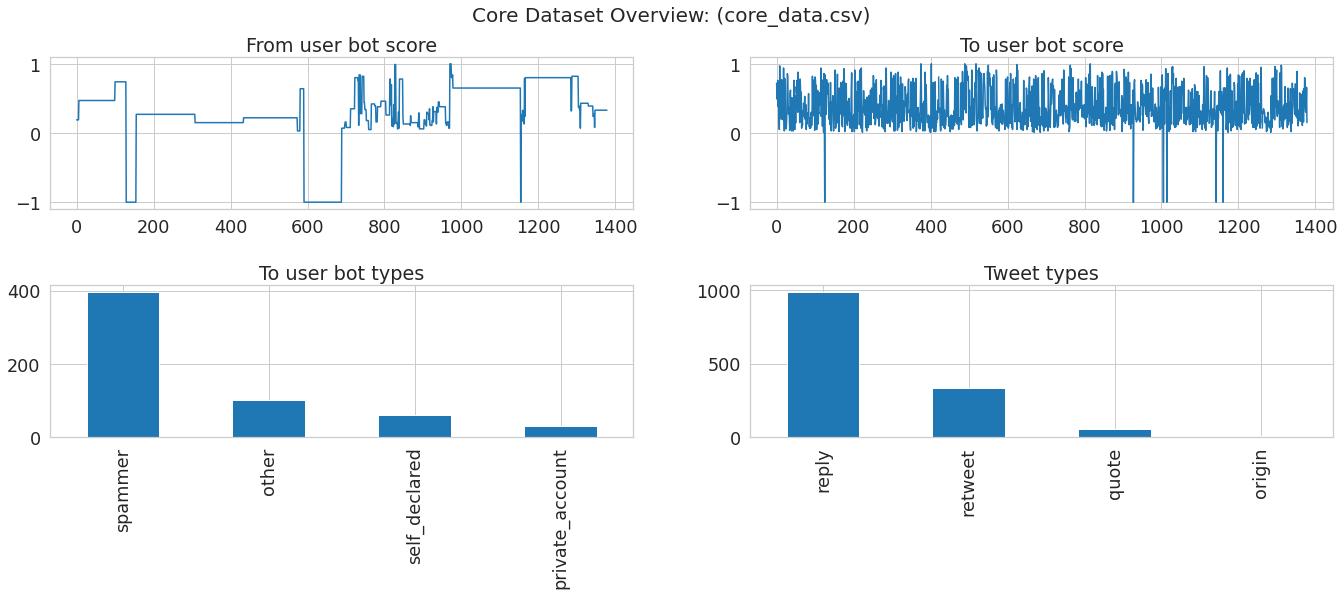

In [39]:
# show only the first 3 rows
display(input_data[0:3])

print("Data Overview:")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(23,7))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
input_data["from_user_botscore"].plot(ax=axes[0, 0]);
axes[0, 0].set_title("From user bot score");
input_data["to_user_botscore"].plot(ax=axes[0, 1]);
axes[0, 1].set_title("To user bot score");
pd.value_counts(input_data["to_user_bot_type"]).plot.bar(ax=axes[1, 0]);
axes[1, 0].set_title("To user bot types");
pd.value_counts(input_data["tweet_type"]).plot.bar(ax=axes[1, 1]);
axes[1, 1].set_title("Tweet types");
fig.suptitle("Core Dataset Overview: (core_data.csv)", fontsize=20)
plt.savefig("./figures/dataset-overview.png")

Among all the columns and rows of data, there are few of the that we can consider essential for the next steps and the will the the following columns:

- __from_user_type__ - [bot / human] Determines if an origin user account is a bot or not. 
- __to_user_type__ - [bot / human ] Determines if an destination user account is a bot or not,
- __from_user_bot_type__ - set of classification to specify what type of bot is the bot account.
- __to_user_bot_type__ set of classification to specify what type of bot is the bot account.

__Bot Types:__

* `fake_follower`: bots purchased to increase follower counts 
* `self_declared`: bots from botwiki.org
* `astroturf`: manually labeled political bots and accounts involved in follow trains that systematically delete content
* `spammer`: accounts labeled as spambots from several datasets
* `financial`: bots that post using cashtags
* `other`: miscellaneous other bots obtained from manual annotation, user feedback, etc.
* `private_account`: twitter bots with protected settings, timeline cannot be accessed.




## Network Visualization
Multiplex network visualization of the dataset. This section will also cover the process of converting the core csv dataset input graph data using networkX and performing various visualization methods for the graph data generated form the dataset

[247, 189, 6, 67, 85, 545, 304, 536, 1, 244, 290, 240, 274, 276, 347, 381, 277, 349, 436, 447, 448, 449, 450, 452]
[2.0, 1.7849462365591398, 1.6344086021505375, 1.3010752688172043, 1.10752688172043, 1.075268817204301, 1.053763440860215, 1.053763440860215, 1.043010752688172, 1.021505376344086, 1.021505376344086, 1.010752688172043, 1.010752688172043, 1.010752688172043, 1.010752688172043, 1.010752688172043, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Generating bot layer graph..
No. of Bot Nodes: 562
No. of Human Nodes: 824
Total Tweets 1374


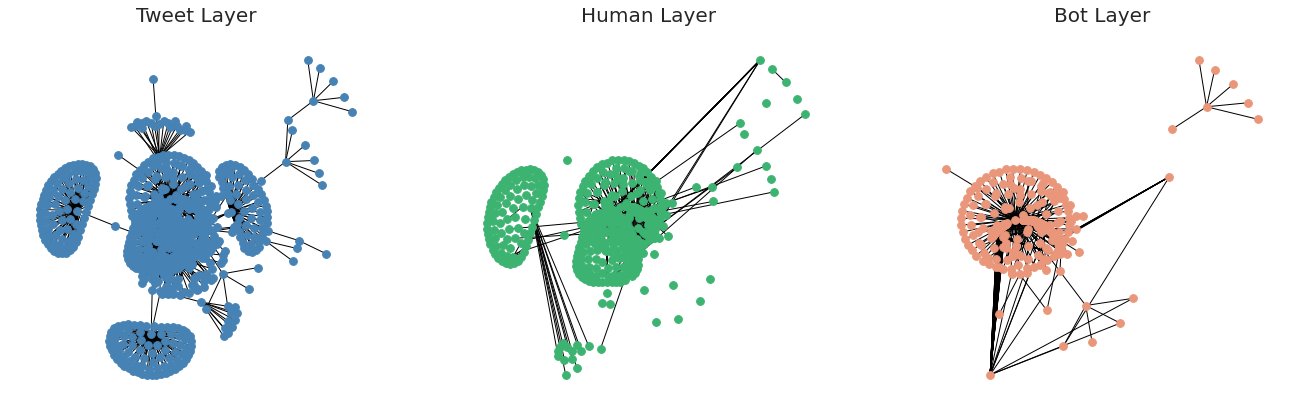

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline

# let's start with the important stuff. pick your colors.
cols = ['steelblue', 'mediumseagreen','darksalmon']
np.random.seed(1)

# Create a set of graph layers
layer_names = ["Tweet Layer", "Human Layer", "Bot Layer"] 
node_colors = {"bot":"red","human":"green"}
mention_edge_color = "blue"
def_edge_color = "grey"


tweets_layer = nx.Graph()
human_layer = nx.Graph()
bot_layer = nx.Graph()

# create data for bot layer

all_bots = {}
all_humans = {}
all_tweets = {}

range_start = 0
range_end = 400
layout_iterations = 100

def createUserNetworkLayers(delimeter,outputData,outputNetwork):
    # get all the delimeter from input_data
    for index, row in input_data[range_start:range_end].iterrows():
        
        from_username = row["from_user_screen_name"]
        to_username = row["to_user_screen_name"]
        is_mention = row["is_mention"]
        
        # process all data based on delimeters
        if row["to_user_type"] == delimeter and to_username not in outputData:
            outputData[to_username] = {"username": to_username,"bot_type": row["to_user_bot_type"],"to": [], "mentions":[], "type": delimeter}
        
        
        if row["from_user_type"] == delimeter and from_username not in outputData:
            data = {"username": from_username,"bot_type": row["from_user_bot_type"],"to":[], "mentions":[], "type": delimeter}  
            if row["to_user_type"] == delimeter:
                data["to"].append(to_username)
                data["mentions"].append(is_mention)
            
            outputData[from_username] = data
        
        if row["from_user_type"] == delimeter and from_username in outputData:
            if row["to_user_type"] == delimeter and to_username not in outputData[from_username]["to"]:
                outputData[from_username]["to"].append(to_username)
                outputData[from_username]["mentions"].append(is_mention)

    # create nodes
    for ix, item, in enumerate(outputData):
        user_node_color = cols[2] if outputData[item]["type"] == "bot" else cols[1]
        outputNetwork.add_nodes_from([(ix,outputData[item])],weight=len(outputData[item]["to"]), color=user_node_color)

    # create edges
    for ix, item in enumerate(outputData):
        if len(outputData[item]["to"]) > 0:
            for y, conn in enumerate(outputData[item]["to"]):
                edge_color = mention_edge_color if outputData[item]["mentions"][y] == True else def_edge_color
                outputNetwork.add_edge(ix,list(outputData.keys()).index(outputData[item]["to"][y]),color=edge_color)


def createTweetsData(inputLayer):
    for node in inputLayer:
        all_tweets[node] = inputLayer[node]


def createTweetsNetworkLayer(data):
    for ix, item, in enumerate(data):
        user_node_color = cols[2] if data[item]["type"] == "bot" else cols[1]
        tweets_layer.add_nodes_from([(ix,data[item])],color=user_node_color)

    for ix, item in enumerate(data):
        if len(data[item]["to"]) > 0:
            for y, conn in enumerate(data[item]["to"]):
                edge_color = mention_edge_color if data[item]["mentions"][y] == True else def_edge_color
                tweets_layer.add_edge(ix,list(data.keys()).index(data[item]["to"][y]), color=edge_color)

raw_layer_data = [all_tweets, all_humans, all_bots]                


# Create connections between layers, by getting the nodes with most connections for each layer
# Only return the nodes with connections
def createLayerConnections(layer_data):
    c_data = []
    conns = []
    for ix, x in enumerate(layer_data):
        c_data.append({
            "node_id": ix,
            "connections": len(layer_data[x]["to"])
        })
    
    c_data = sorted(c_data, key = lambda i: i['connections'],reverse=True)

    for ix, x in enumerate(c_data):
        if x["connections"] > 0:
            conns.append(x["node_id"])
    
    return conns

# this function will create custom with of connections between layers of the multi layer network chart
def fetchConnectionDensity(layer_data):
    c_data = []
    conns = []
    conns_density = []
    for ix, x in enumerate(layer_data):
        c_data.append({
            "node_id": ix,
            "connections": len(layer_data[x]["to"])
        })
    
    c_data = sorted(c_data, key = lambda i: i['connections'],reverse=True)

    # get number of connections for the connected nodes
    for ix, x in enumerate(c_data):
        if x["connections"] > 0:
            conns.append(x["connections"])

    # calculate connection density by normalizing the number of connections between layers
    for ix, cn in enumerate(conns):
        max_density = max(conns)
        min_density = min(conns)
        c_density = ((cn-min_density) / (max_density - min_density)) +1 
        conns_density.append(c_density)
    
    return conns_density
          
 


graphs = [tweets_layer, human_layer, bot_layer]

createUserNetworkLayers("bot",all_bots,bot_layer)
createUserNetworkLayers("human",all_humans,human_layer)
createTweetsData(all_bots)            
createTweetsData(all_humans) 
createTweetsNetworkLayer(all_tweets)

print(createLayerConnections(all_bots))
print(fetchConnectionDensity(all_bots))


pos = nx.kamada_kawai_layout(tweets_layer) # assuming common node location

# prepare subplots

fig, all_axes = plt.subplots(1, 3, figsize=(23,7))
ax = all_axes.flat

for i, gr in enumerate(graphs):
    ax[i].set_title(layer_names[i], fontsize=20)
    nx.draw(gr,pos, node_size=60, ax=ax[i], node_color=cols[i])

plt.savefig("./figures/per-layer-visualization.png")


print("Generating bot layer graph..")
print("No. of Bot Nodes:",len(all_bots))
print("No. of Human Nodes:",len(all_humans))
print("Total Tweets",len(all_tweets))

## Multiplex Network Visualization
This section covers the extended execution of the multilayer / multiplex Network visualization. This implementation is done using matplotlib and networkX, full implementation referrence can be seen here: *https://nbviewer.org/github/jkbren/matplotlib-multilayer-network/blob/master/matplotlib-multilayer-networks.ipynb*


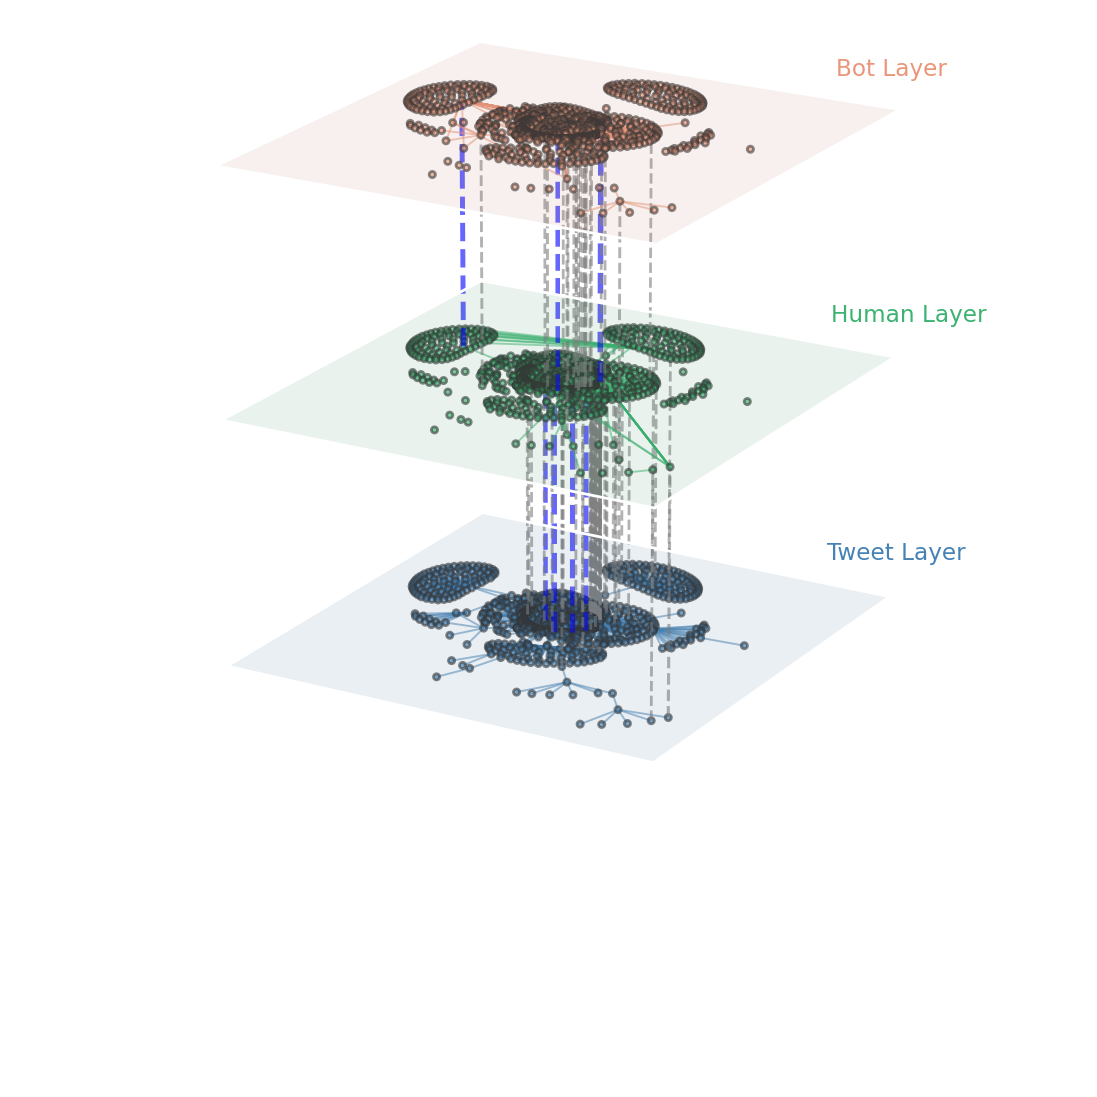

In [41]:
# Set height and width of figure
w = 8
h = 7


def blayerEdgeColors(cd):
    cxm = []
    
    for cxs in cd:
        if(cxs > 1.45):
            cxm.append("blue")
        else: 
            cxm.append("grey")    
    return cxm

fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=200, subplot_kw={'projection':'3d'})

for gi, G in enumerate(graphs):
    # node positions
    xs = list(list(zip(*list(pos.values())))[0])
    ys = list(list(zip(*list(pos.values())))[1])
    zs = [gi]*len(xs) # set a common z-position of the nodes 

    # node colors
    cs = [cols[gi]]*len(xs)
    
    # if you want to have between-layer connections
    if gi > 0:
        thru_nodes = createLayerConnections(raw_layer_data[gi])
        lines3d_between = [(list(pos[i])+[gi-1],list(pos[i])+[gi]) for i in thru_nodes]
        between_lines = Line3DCollection(lines3d_between, zorder=gi, color=blayerEdgeColors(fetchConnectionDensity(raw_layer_data[gi])),
                                         alpha=0.6, linestyle='--', linewidth=fetchConnectionDensity(raw_layer_data[gi]))
        ax.add_collection3d(between_lines)

    # add within-layer edges 
    lines3d = [(list(pos[i])+[gi],list(pos[j])+[gi]) for i,j in G.edges()]
    line_collection = Line3DCollection(lines3d, zorder=gi, color=cols[gi], alpha=0.5, linewidth=0.7)
    ax.add_collection3d(line_collection)
    
    # now add nodes
    ax.scatter(xs, ys, zs, c=cs, s=5, edgecolors='.2', marker='o', alpha=0.6, zorder=gi+1)
    
    # add a plane to designate the layer
    xdiff = max(xs)-min(xs)
    ydiff = max(ys)-min(ys)
    ymin = min(ys)-ydiff*0.1
    ymax = max(ys)+ydiff*0.1
    xmin = min(xs)-xdiff*0.1 * (w/h)
    xmax = max(xs)+xdiff*0.1 * (w/h)
    xx, yy = np.meshgrid([xmin, xmax],[ymin, ymax])
    zz = np.zeros(xx.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)

    # add label
    layertext = ax.text(0.0, 1.2, gi*0.95+0.5, layer_names[gi],
                        color=cols[gi], fontsize='small', zorder=1e5, ha='left', va='center')

# set them all at the same x,y,zlims
ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_xlim(min(xs)-xdiff*0.1,max(xs)+xdiff*0.1)
ax.set_zlim(-0.3, len(graphs) - 2 + 0.1)

# select viewing angle
angle = 30
height_angle = 21
ax.view_init(height_angle, angle)

# how much do you want to zoom into the fig
ax.dist = 13.5

ax.set_axis_off()

plt.savefig("./figures/multiplex-network.png")



## Functional Connectivity
A set of visualization demonstrating functional connectivity
1. Check compatibility with NeuroPredict
2. If not compatible try to match all visualizations from neuro predict

## Multilayer network legend
legend is separated fromthe figure for better layout options

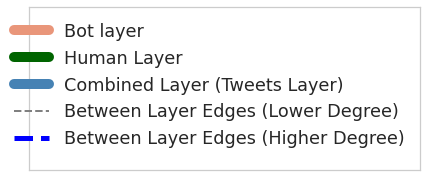

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,3))
ax.plot([0],[0],color="darksalmon",label="Bot layer", linewidth=10)
ax.plot([0],[0],color="darkgreen",label="Human Layer", linewidth=10)
ax.plot([0],[0],color="steelblue",label="Combined Layer (Tweets Layer)", linewidth=10)
ax.plot([0],[0],color="grey",label="Between Layer Edges (Lower Degree)", linewidth=2, linestyle="--")
ax.plot([0],[0],color="blue",label="Between Layer Edges (Higher Degree)", linewidth=5, linestyle="--")
ax.legend(frameon=False)

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

plt.savefig("./figures/multiplex-layer-legend.png")


### Graph Network Infomation
The values listed below pertains to the details of the network, like No. of Nodes, No. of Edges, etc. Note that these are data driven values that changes along with the input dataset

> Note: The Degree mapping of each between layer edges is directly proportial to the results on the 2nd network analysis, influential nodes table. The value differences is a seeded value of 5 that was added in for visualization purposes.

In [43]:

graph_network_info = []

layer_info = {

}
print("Nodes and Edges per layer")
for i, gr in enumerate(graphs):
    print(layer_names[i])
    print("Number of nodes:",gr.number_of_nodes())
    print("Number of edges:",gr.number_of_edges())
    
print("")  

between_layer_names = ["-", "Human Layer to Tweets Layer", "Bot Layer to Human Layer"]

print("Between Layer Edges:")
for i, gr in enumerate(graphs):
    if i > 0:
        print(between_layer_names[i])
        print("No. of Beetween Layer Edges",len(createLayerConnections(raw_layer_data[i])))


Nodes and Edges per layer
Tweet Layer
Number of nodes: 1374
Number of edges: 693
Human Layer
Number of nodes: 824
Number of edges: 533
Bot Layer
Number of nodes: 562
Number of edges: 316

Between Layer Edges:
Human Layer to Tweets Layer
No. of Beetween Layer Edges 61
Bot Layer to Human Layer
No. of Beetween Layer Edges 24


## Visualizing Network Communities
This segment of the visualization uses the nxviz library to visualize the different subgraphs or communities fro the different layers.
below is the plot of the adjacency matrix of each layer on the multilayer network.

## Adjacency Matrix
This visualization is done using Imshow from matplotlib and a function from networkX converts the network graph data into an adjacency matrix array. An algorithm was used called nx.k_shell, a decompostion function that helps filter disconnected parts of the graph data.

for the x and y labesl of the adjacency matrix, it will cover all the nodes of the network represented in numbers

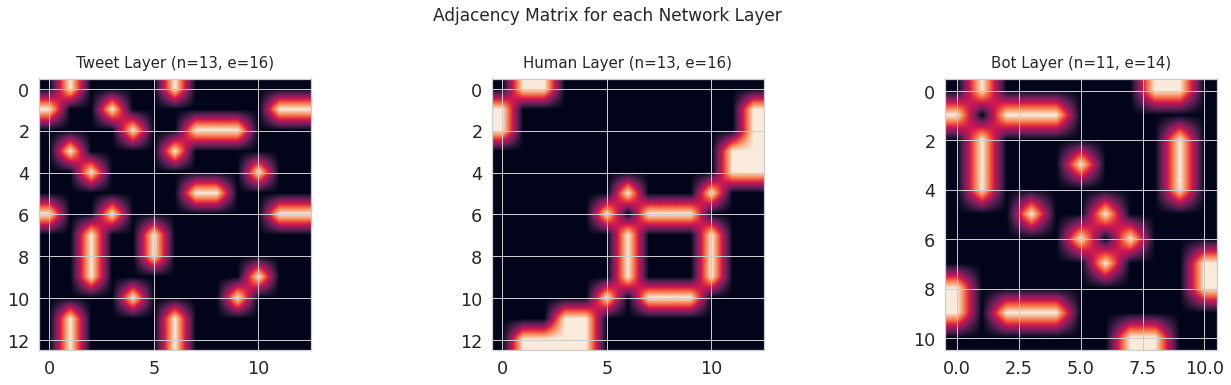

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(23, 5))

# Plot adjacency Matrix for each layer
for i,g in enumerate(graphs):
    g = nx.k_shell(g)
    # covert network data to adjacency matrix array
    ajD = nx.adjacency_matrix(g).toarray()
    # limit array size, for uniformity
    axs[i].imshow(ajD, interpolation="bilinear")
    axs[i].set_title(f"{layer_names[i]} (n={g.number_of_nodes()}, e={g.number_of_edges()})", fontsize=15, y=1.02)

fig.suptitle('Adjacency Matrix for each Network Layer', fontsize=17, y=1.08 )
plt.savefig("./figures/per-layer-adj-matrix.png")


## Network Communities Using (NxViz Circos Plot)


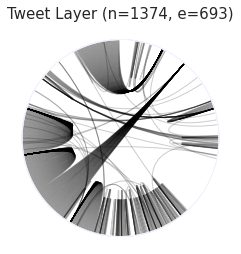

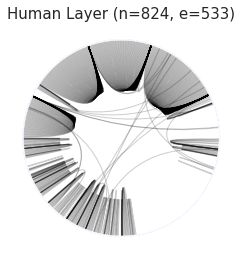

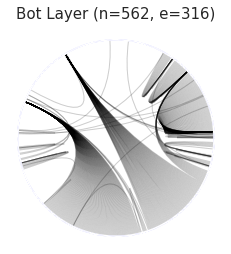

In [45]:
import nxviz as nv
# plot each circos using nxviz


for i,g in enumerate(graphs):
    nv.CircosPlot(g)
    ax = plt.gca()
    ax.set_title(f"{layer_names[i]} (n={g.number_of_nodes()}, e={g.number_of_edges()})", fontsize=15, y=1.02)
    plt.savefig(f"./figures/{layer_names[i]} - Circos plot.png")



## Network Statistics
This part of the research covers the implementation of Network Statistics for the project, According to the research outline.

## Assortativity
Assortativity, or assortative mixing is a preference for a network's nodes to attach to others that are similar in some way. Though the specific measure of similarity may vary, network theorists often examine assortativity in terms of a node's degree

Degree Assortativity Coefficient
Tweet Layer: -0.5132644169058195
Human Layer: -0.49996334966236905
Bot Layer: -0.6405103702533236
 
Assortativity Degree Mixing Matrix
Assortativity Node Degree
Tweet Layer: 1386
Human Layer: 1066
Bot Layer: 632


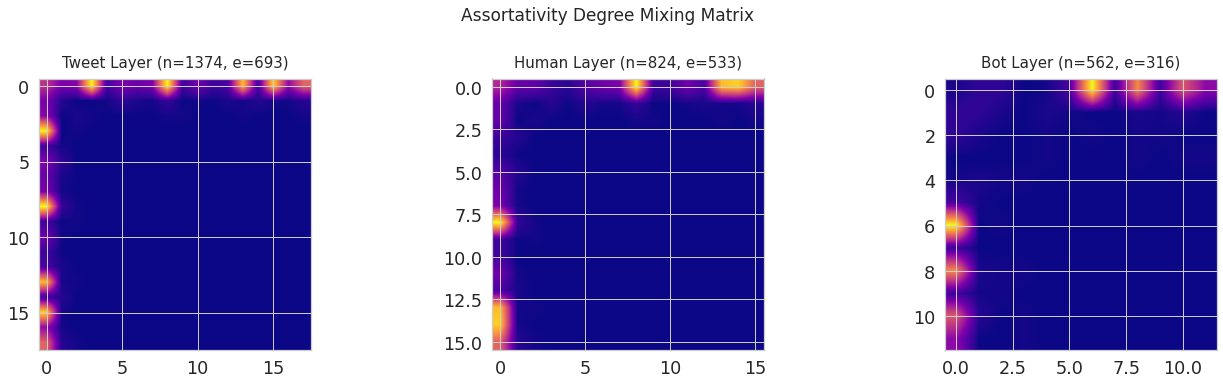

In [46]:
print(f"Degree Assortativity Coefficient")
for i, g in enumerate(graphs):
    print(f"{layer_names[i]}: {nx.degree_assortativity_coefficient(g)}")

print(" ")

print(f"Assortativity Degree Mixing Matrix")

fig, axs = plt.subplots(1, 3, figsize=(23, 5))

# Plot adjacency Matrix for each layer
for i,g in enumerate(graphs):
    # covert network data to adjacency matrix array
    ajD = nx.degree_mixing_matrix(g)
    # limit array size, for uniformity
    axs[i].imshow(ajD, interpolation="bilinear", cmap="plasma")
    axs[i].set_title(f"{layer_names[i]} (n={g.number_of_nodes()}, e={g.number_of_edges()})", fontsize=15, y=1.02)

fig.suptitle('Assortativity Degree Mixing Matrix', fontsize=17, y=1.08 )

assortativity_node_degrees = []

print(f"Assortativity Node Degree")
for i, g in enumerate(graphs):
    #TODO: save dataset of node degree 
    nDeg = nx.node_degree_xy(g)
    print(f"{layer_names[i]}: {len(list(nDeg))}")

plt.savefig("./figures/degree-mixing-assortativity.png")



## Modularity
Returns the modularity of the given partition of the graph, and network layers using the Louvain Community Detection method.

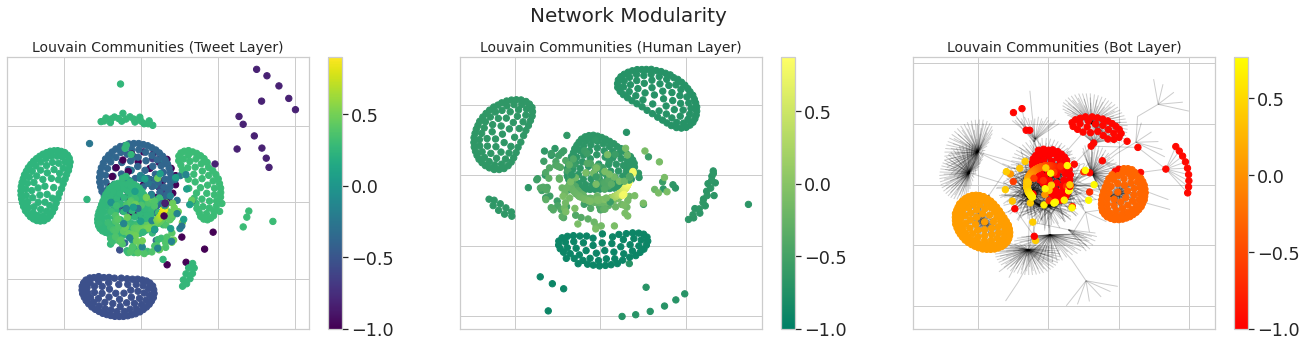

In [47]:
import community as community_louvain
import matplotlib.cm as cm


fig, all_axes = plt.subplots(1, 3, figsize=(23,5))
ax = all_axes.flat
fig.suptitle("Network Modularity",y=1.02, fontsize=20)

for i, g in enumerate(graphs):
    G = g
    # color maps
    cmaps = ["viridis","summer","autumn"]
    # compute the best partition
    partition = community_louvain.best_partition(G)
    # draw the graph
    pos = nx.kamada_kawai_layout(G)
    # color the nodes according to their partition
    cmap = cm.get_cmap(cmaps[i], max(partition.values()) + 1)
    ax[i].set_title(f"Louvain Communities ({layer_names[i]})", fontsize=14)

    network_modularity = community_louvain.modularity(partition, G)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=network_modularity))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i])
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, ax=ax[i], cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.2)

plt.savefig("./figures/network-modularity.png")


## Network Polarization
> Explore visualizations from this paper

https://link.springer.com/article/10.1007/s13278-021-00779-3
1. Dendogram Visualization (Explore if possible) - https://python-louvain.readthedocs.io/en/latest/api.html



## Network Decomposition
network decomposition per layer using networkx's k-core decomposition algorithm

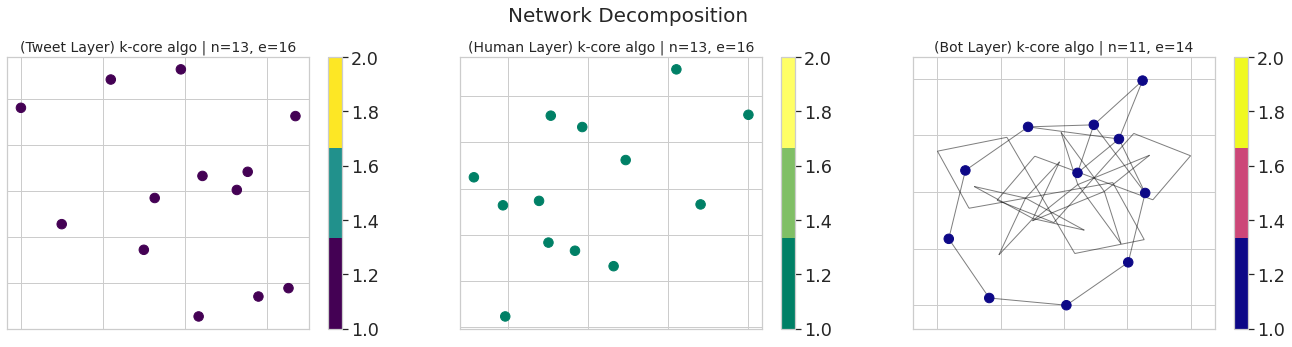

In [48]:
import matplotlib.cm as cm

fig, all_axes = plt.subplots(1, 3, figsize=(23,5))
ax = all_axes.flat
fig.suptitle("Network Decomposition",y=1.02, fontsize=20)

for i, g in enumerate(graphs):
    # convert graph to network decomposition subgraph
    G = nx.k_core(g)
    core_number = nx.core_number(G)
    cmaps = ["viridis","summer","plasma"]
    pos = nx.kamada_kawai_layout(G)
    cmap = cm.get_cmap(cmaps[i], max(core_number.values()) + 1)
    ax[i].set_title(f"({layer_names[i]}) k-core algo | n={G.number_of_nodes()}, e={G.number_of_edges()}", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=2))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i])
    nx.draw_networkx_nodes(G, pos, core_number.keys(),  node_size=90, ax=ax[i], cmap=cmap, node_color=list(core_number.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.savefig("./figures/network-decomposition.png")

## Multilayer Network Analysis
Continuation of network statistics, calculate Entanglement for the network

## Create Multi Layer network Dataset file:
Create dataset file for py3plex

In [49]:
layers_edgelist = []

mx_layers = ["tweets_layer", "human_layer", "bot_layer"]

# generate a custom edgelist and combinem them for all layers
for i, g in enumerate(graphs):
    networkedgeList = nx.generate_edgelist(g, data=False)
    print(f"Generating Edgelist for {mx_layers[i]}")
    for ix, x in enumerate(networkedgeList):
        e = x.replace(" ", f" {mx_layers[i]} ")
        edge_line = f"{e} {mx_layers[i]} 1"
        layers_edgelist.append(edge_line)

# write edgelist to file "mxlist.txt"
with open('./dataset/mxlist.txt', 'w') as f:
    for item in layers_edgelist:
        f.write("%s\n" % item)

print("=================================")
print("Custom data generation Completed!")

Generating Edgelist for tweets_layer
Generating Edgelist for human_layer
Generating Edgelist for bot_layer
Custom data generation Completed!


## Calculate Network Layer Entaglement
Calculate network entangled states using py3plex

In [50]:
from py3plex.core import multinet
from py3plex.algorithms.multilayer_algorithms.entanglement import compute_entanglement_analysis

# visualization from a simple file
multilayer_network = multinet.multi_layer_network().load_network(
    "./dataset/mxlist.txt", directed=True, input_type="multiedgelist")
multilayer_network.basic_stats()

analysis = compute_entanglement_analysis(multilayer_network)

print("%d connected components of layers" % len(analysis))
for i, b in enumerate(analysis):
    print('--- block %d' % i)
    layer_labels = b['Layer entanglement'].keys()
    print('Covering layers: %s' % layer_labels)

    print('Entanglement intensity: %f' % b['Entanglement intensity'])
    print('Layer entanglement: %s' % b['Layer entanglement'])
    print('Entanglement homogeneity: %f' % b['Entanglement homogeneity'])
    print('Normalized homogeneity: %f' % b['Normalized homogeneity'])

-------------------- 
 Computing core stats of the network 
 --------------------
MultiDiGraph with 1635 nodes and 1542 edges
Number of unique node IDs: 256
1 connected components of layers
--- block 0
Covering layers: dict_keys(['tweets_layer', 'human_layer', 'bot_layer'])
Entanglement intensity: 0.244389
Layer entanglement: {'tweets_layer': 0.9093002868817468, 'human_layer': 0.0037759588196215298, 'bot_layer': 0.4161234557337104}
Entanglement homogeneity: 0.767414
Normalized homogeneity: 0.556914


## Calculate Entanglement Per node
Use Scipy and Sklearn to calculate entanglement per node

beta =  169.00877157012076


100% |########################################################################|


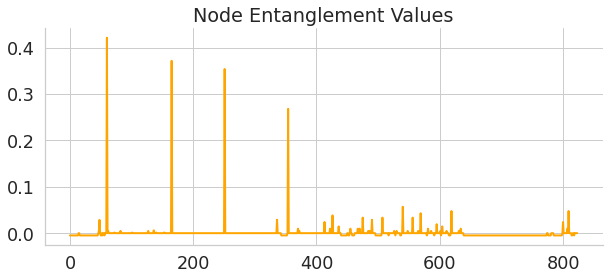

In [51]:
from __future__ import division
import numpy as np
import networkx as nx
import time 
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import operator
from progressbar import ProgressBar
from random import seed, random
import scipy as sci
import sklearn
import seaborn as sns
from sklearn import metrics
import os

#utility for line plotting
def LinePlot(data, lw, title):
    figx = (10,4)
    fig, ax = plt.subplots(figsize=figx)
    ax.spines["top"].set_visible(False) 
    ax.spines["right"].set_visible(False) 
    ax.set_title(f"{title}")

    ax.plot(data, color="orange", linewidth=lw);
    plt.savefig(f"./figures/{title}.png")




def entropy(G,beta):
    ### Calculates the entropy of network G at beta as diffusion time, defined at https://doi.org/10.1038/s42005-021-00633-0 
    Ls = np.sort(nx.laplacian_spectrum(G))
    Z = np.sum(np.exp(-beta*Ls))
    p = np.exp(-beta*Ls)/Z
    p=np.delete(p,np.where(p<10**-20))
    #p=np.delete(p,np.where(p<10**-8))
    S = np.sum( -p * np.log2(p) )
    return S

def entropy_diff_time_small(G):   
    ### Calculates the entropy of network G at small diffusion time, defined at https://doi.org/10.1038/s42005-021-00633-0 
    Ls = np.sort(nx.laplacian_spectrum(G))
    diff_time = Ls[np.where(Ls>10**-12)[0]][0]
    k_ = len(G.edges())/len(G.nodes())
    beta = -np.log(.9)/diff_time
    print('beta = ',beta)
    sp = np.exp(-beta*Ls)
    Z = np.sum(sp)
    p = np.exp(-beta*Ls)/Z
    p=np.delete(p,np.where(p<10**-20))
    S = np.sum( -p * np.log2(p) )
    return S,beta

def entropy_diff_time_mid(G):
    ### Calculates the entropy of network G at middle diffusion time, defined at https://doi.org/10.1038/s42005-021-00633-0
    Ls = np.sort(nx.laplacian_spectrum(G))
    diff_time = Ls[np.where(Ls>10**-12)[0]][0]
    k_ = len(G.edges())/len(G.nodes())
    beta = -np.log(.33)/diff_time
    print('beta = ',beta)
    sp = np.exp(-beta*Ls)
    Z = np.sum(sp)
    p = np.exp(-beta*Ls)/Z
    p=np.delete(p,np.where(p<10**-20))
    S = np.sum( -p * np.log2(p) )
    return S,beta

def entropy_diff_time_large(G):
    ### Calculates the entropy of network G at large diffusion time, defined at https://doi.org/10.1038/s42005-021-00633-0
    Ls = np.sort(nx.laplacian_spectrum(G))
    diff_time = Ls[np.where(Ls>10**-12)[0]][0]
    k_ = len(G.edges())/len(G.nodes())   
    beta = -np.log(.01)/diff_time
    print('beta = ',beta)
    sp = np.exp(-beta*Ls)
    Z = np.sum(sp)
    p = np.exp(-beta*Ls)/Z
    p=np.delete(p,np.where(p<10**-20))
    S = np.sum( -p * np.log2(p) )
    return S,beta

def entanglement_small(G):
    ### Calculates network entanglement of all nodes of network G at small diffusion time, defined at https://doi.org/10.1038/s42005-021-00633-0
    pbar = ProgressBar()
    S_1,beta = entropy_diff_time_small(G)
    ent = {}
    nodes = list(G.nodes())
    for i in pbar(range(len(nodes))):
        G_i=G.copy()
        k = G_i.degree[nodes[i]]
        G_i.remove_node(nodes[i])
        S_2 = entropy(G_i,beta) 
        G_star = nx.star_graph(k+1)
        S_star = entropy(G_star,beta)        
        S_2 = S_2 + S_star
        ent[nodes[i]]=S_2 - S_1
    return ent

def entanglement_mid(G):
    ### Calculates network entanglement of all nodes of network G at middle diffusion time defined at https://doi.org/10.1038/s42005-021-00633-0
    pbar = ProgressBar()
    S_1,beta = entropy_diff_time_mid(G)
    ent = {}
    nodes = list(G.nodes())
    for i in pbar(range(len(nodes))):
        G_i=G.copy()
        k = G_i.degree[nodes[i]]
        G_i.remove_node(nodes[i])
        S_2 = entropy(G_i,beta) 
        G_star = nx.star_graph(k+1)
        S_star = entropy(G_star,beta)  
        S_2 = S_2 + S_star
        ent[nodes[i]]=S_2 - S_1
    return ent

def entanglement_large(G):
    ### Calculates network entanglement of all nodes of network G at large diffusion time defined at https://doi.org/10.1038/s42005-021-00633-0
    pbar = ProgressBar()
    S_1,beta = entropy_diff_time_large(G)
    ent = {}
    nodes = list(G.nodes())
    for i in pbar(range(len(nodes))):
        G_i=G.copy()
        k = G_i.degree[nodes[i]]
        G_i.remove_node(nodes[i])
        S_2 = entropy(G_i,beta) 
        G_star = nx.star_graph(k+1)
        S_star = entropy(G_star,beta)
        S_2 = S_2 + S_star
        ent[nodes[i]]=S_2 - S_1
    return ent

G = graphs[1]
# NE_small=entanglement_small(G)   # calculates the entanglement at short-range interactions
NE_mid=entanglement_mid(G)   # calculates the entanglement at middle-range interactions
# NE_large=entanglement_large(G)   # calculates the entanglement at large-range interactions
LinePlot(list(NE_mid.values()),2,f"Node Entanglement Values")


## Network Analysis 
This section will cover the implementation of the following Network Properties for each network layer: This section will also cover plotting centralities, destributions and custom graph models
- number of edges and vertices
- node connectedness
- diameter
- average path length
- density
- transitivity
- node clustering coefficient
- average degree
- degree distribution
- neighborhood
- connectedness of vertices
- distance between two vertices
- clustering coefficient (vertices)
- degree of adjacent vertices
- eigenvector centrality
- betweeness centrality

For a stochastic graph model to be rendered the undirected graph must be converted to a directed graph before visualization

Network Layer: Tweet Layer
Network Layer: Human Layer
Network Layer: Bot Layer


layer_name  no_of_nodes  node_connectedness  diameter  \
0  Tweet Layer         1374               False     False   
1  Human Layer          824               False     False   
2    Bot Layer          562               False     False   

   average_path_length   density  transitivity  clustering_coefficient  \
0                False  0.000735             0                     0.0   
1                False  0.001572             0                     0.0   
2                False  0.002005             0                     0.0   

   average_degree  neighborhood  vertice_connectedness  \
0        1.008734             1                   True   
1        1.293689             0                  False   
2        1.124555             3                   True   

   clustering_coeffiecient_vertices  degree_adjacent_vertices  
0                                 0                         1  
1                                 0                         0  
2                                 0                         3

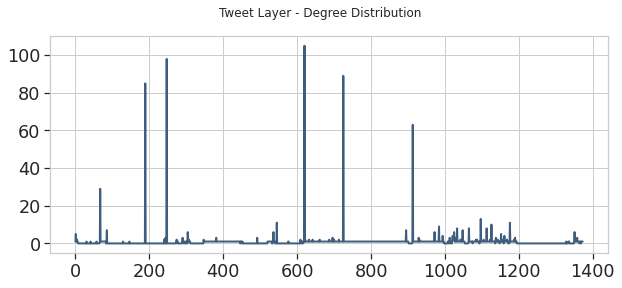

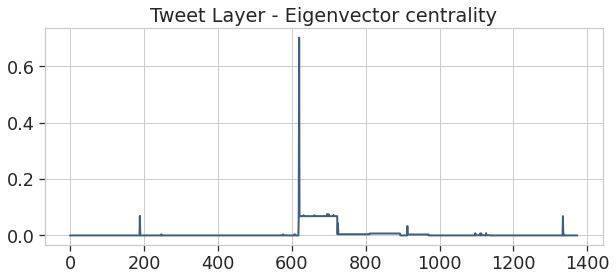

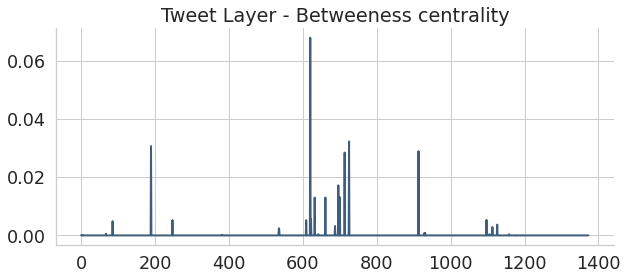

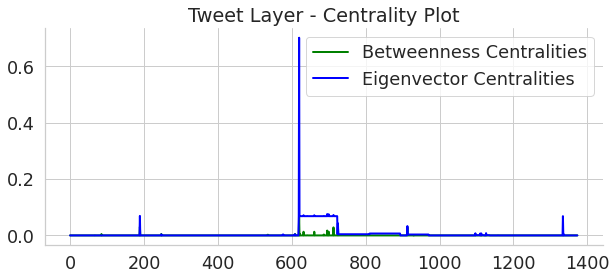

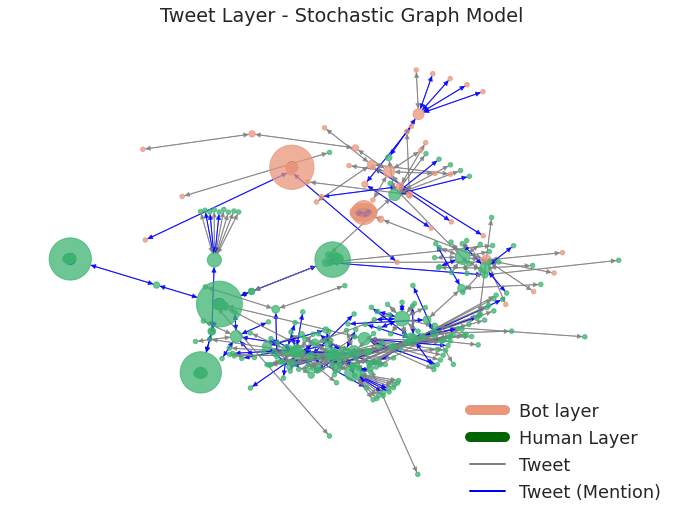

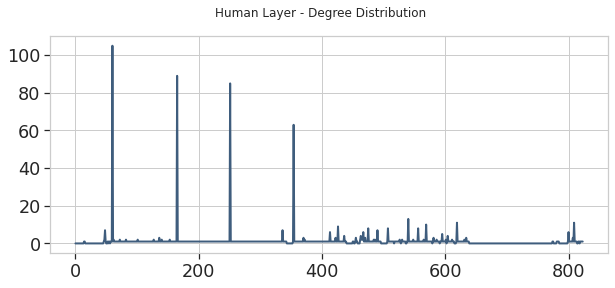

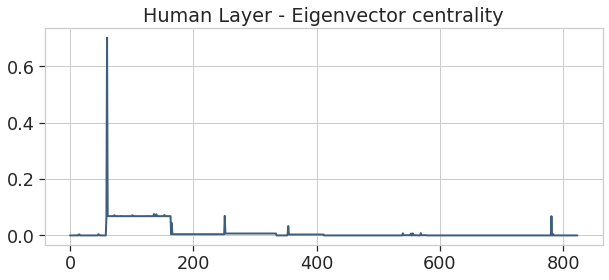

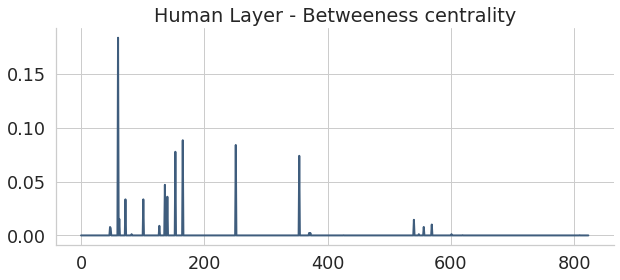

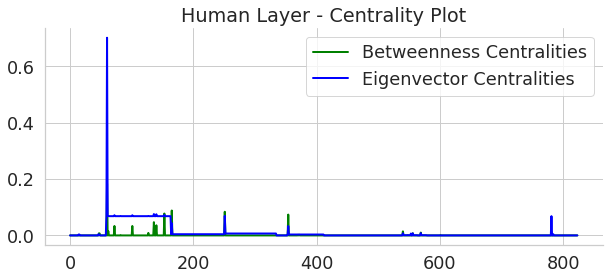

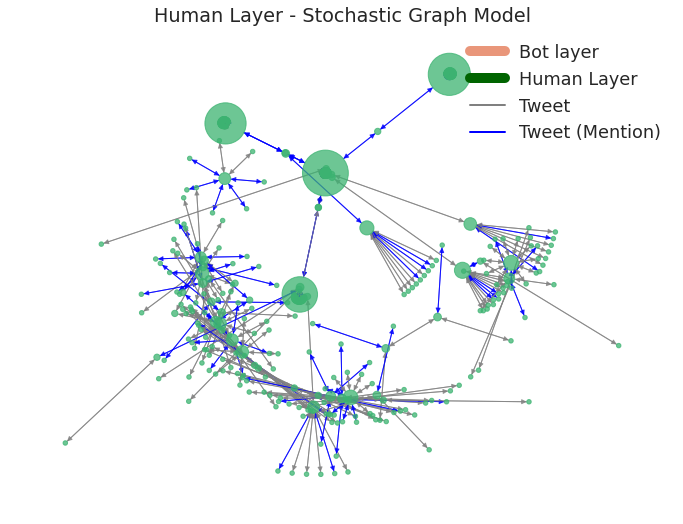

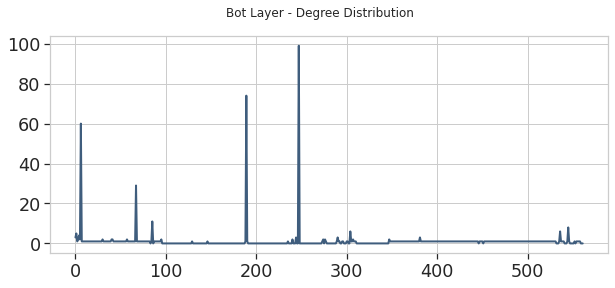

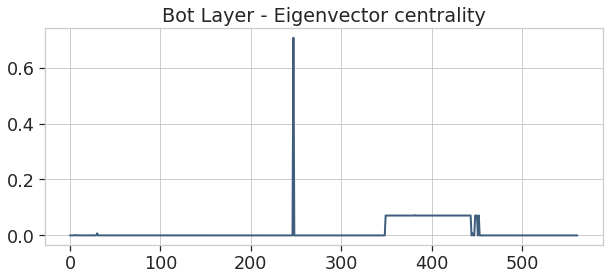

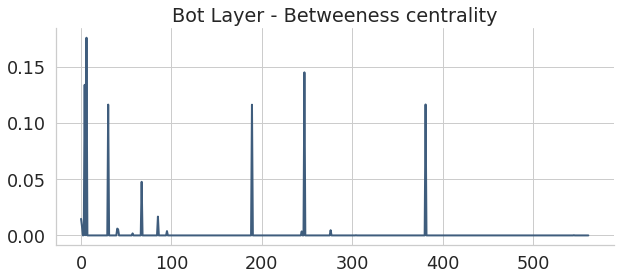

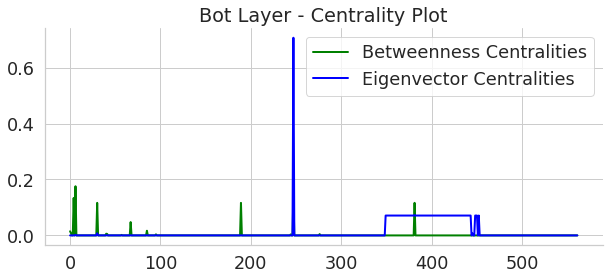

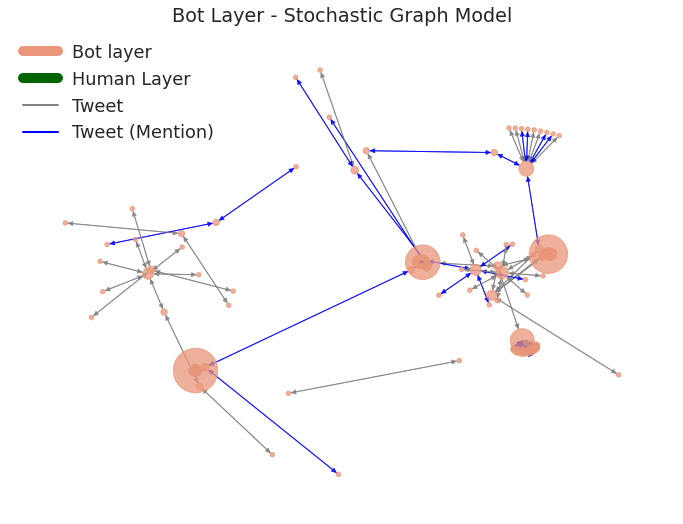

In [52]:
network_stats_dataframe = []

def fetchNetworkStats(gx, i):
    print(f"Network Layer: {layer_names[i]}")
    is_connected = nx.is_connected(gx)
    netstat = {
        "layer_name": layer_names[i],
        "no_of_nodes": gx.number_of_nodes(),
        "node_connectedness": is_connected,
        "diameter": False,
        "average_path_length": False,
        "density": nx.density(gx),
        "transitivity": nx.transitivity(gx),
        "clustering_coefficient": nx.average_clustering(gx),
        "average_degree": np.mean([i[1] for i in gx.degree()]), 
        "neighborhood":  len((list(nx.all_neighbors(gx, 0)))),
        "vertice_connectedness": nx.has_path(gx, 0,1),
        "clustering_coeffiecient_vertices": nx.clustering(gx, 0),
        "degree_adjacent_vertices": gx.degree(0)
    }

    # check connection dependent statistic algos
    if is_connected == True:
        netstat["diameter"] = nx.diameter(gx)
        netstat["average_path_length"] = nx.average_shortest_path_length(x)

       
    network_stats_dataframe.append(netstat)

    figx = (10,4)
    lw = 2

    # plot degree distribution via histogram
    degs = [i[1] for i in gx.degree()]
    fig, ax = plt.subplots(figsize=figx)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()  

    ax.plot(degs, color="#3F5D7D",  linewidth=lw);
    fig.suptitle(f"{layer_names[i]} - Degree Distribution")
    plt.savefig(f"./figures/{layer_names[i]} - Degree Distribution.png")


    # eigen centralities
    eigen_centralities = nx.eigenvector_centrality(gx, max_iter=600).values()

    fig, ax = plt.subplots(figsize=figx)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()  
    ax.set_title(f"{layer_names[i]} - Eigenvector centrality")
  
    ax.plot(eigen_centralities, color="#3F5D7D", linewidth=lw);

    # plot betweeness centrality
    between_centralities = nx.betweenness_centrality(gx).values()

    fig, ax = plt.subplots(figsize=figx)
    ax.spines["top"].set_visible(False) 
    ax.spines["right"].set_visible(False) 
    ax.set_title(f"{layer_names[i]} - Betweeness centrality")
    plt.savefig(f"./figures/{layer_names[i]} - Betweeness centrality.png")


    ax.plot(between_centralities, color="#3F5D7D", linewidth=lw);

    # display unified centrality plot for the Network Layer
    fig, ax = plt.subplots(figsize=figx)
    ax.spines["top"].set_visible(False) 
    ax.spines["right"].set_visible(False) 
    ax.set_title(f"{layer_names[i]} - Centrality Plot")
    ax.plot(between_centralities, color="green", linewidth=lw, label="Betweenness Centralities");
    ax.plot(eigen_centralities, color="blue", linewidth=lw, label="Eigenvector Centralities");
    ax.legend()
    plt.savefig(f"./figures/{layer_names[i]} - Centrality Plot.png")


    # display Stochastic Graph Model
    # convert to stochastic_graph
    sDigx = nx.stochastic_graph((gx.to_directed()))  
    node_colors = list(nx.get_node_attributes(sDigx,'color').values())
    edge_colors = list(nx.get_edge_attributes(sDigx,'color').values())

    fig, ax = plt.subplots(figsize=(12, 9))
    nx.draw(sDigx, 
            pos=nx.kamada_kawai_layout(sDigx),
            # with_labels=True,
            ax=ax, 
            node_size=[i[1]*10 for i in sDigx.degree()], 
            node_color=node_colors, 
            edge_color=edge_colors,
            width=1.0,
            font_size=10.0,
            font_color="#002966",
            alpha=0.75)
    ax.set_title(f"{layer_names[i]} - Stochastic Graph Model")
    ax.plot([0],[0],color="darksalmon",label="Bot layer", linewidth=10)
    ax.plot([0],[0],color="darkgreen",label="Human Layer", linewidth=10)
    ax.plot([0],[0],color="grey",label="Tweet", linewidth=2)
    ax.plot([0],[0],color="blue",label="Tweet (Mention)", linewidth=2)
    ax.legend(frameon=False)

    plt.savefig(f"./figures/{layer_names[i]} - Stochastic Graph Model.png")

   
# display plots per layer
for i, g in enumerate(graphs):
    fetchNetworkStats(g, i)

# print table
netstatTable = pd.DataFrame(network_stats_dataframe)
display(netstatTable)

#create csv file
netstatTable.to_csv("per_layer_network_stats.csv")


The Stochastic graphs for each layer can be intepreted by the following properties
- Node Size is based on Node Degree
- Node Color is based on User Type (Bot / Human)
- Edge Color is based on if the tweet is a mention or not

## Network Clique Algorithms
Clique Algorithms using NetworkX, will only using the view fetch functions listed bellow

- enumerate_all_cliques - Done
- find_cliques - Done
- make_max_clique_graph - Done
- make_clique_bipartite - Done
- graph_clique_number - Done
- graph_number_of_cliques - Done
- node_clique_number - Done
- number_of_cliques - Done
- cliques_containing_node - Done
- max_weight_clique - Done

Layer: Tweet Layer


{'graph_clique_number': 2,
 'graph_number_of_cliques': 1325,
 'max_weight_clique': ([1373, 545], 2)}

Layer: Human Layer


{'graph_clique_number': 2,
 'graph_number_of_cliques': 784,
 'max_weight_clique': ([823, 809], 2)}

Layer: Bot Layer


{'graph_clique_number': 2,
 'graph_number_of_cliques': 558,
 'max_weight_clique': ([558, 545], 2)}

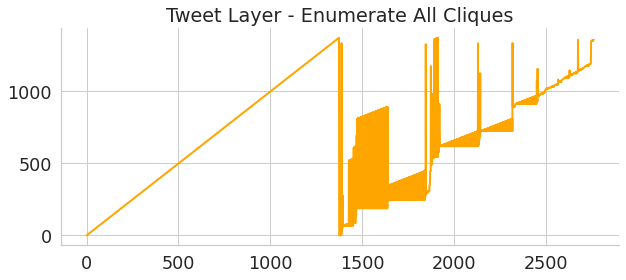

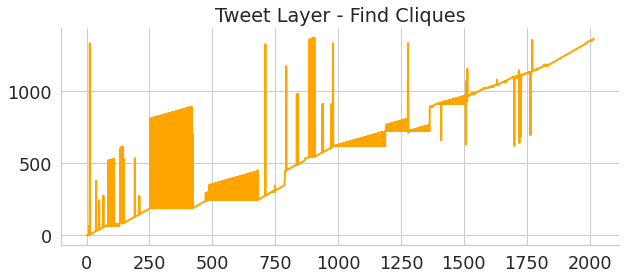

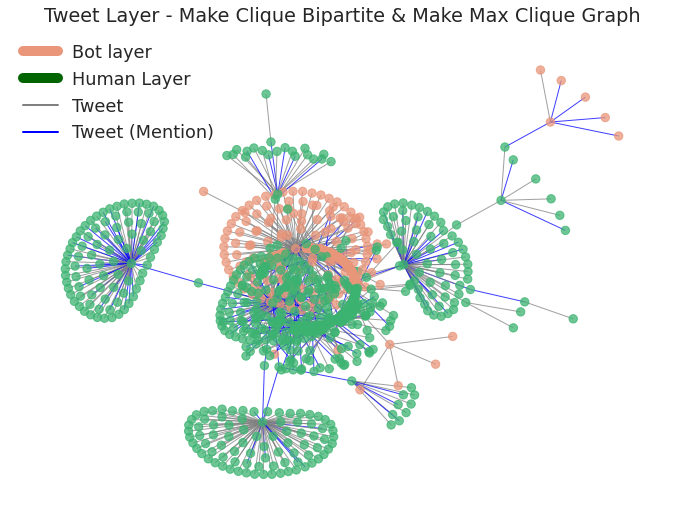

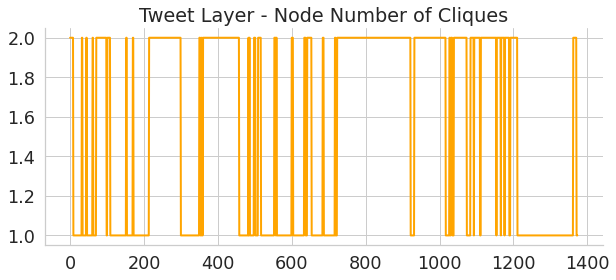

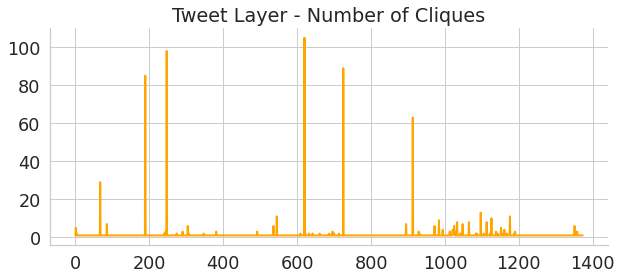

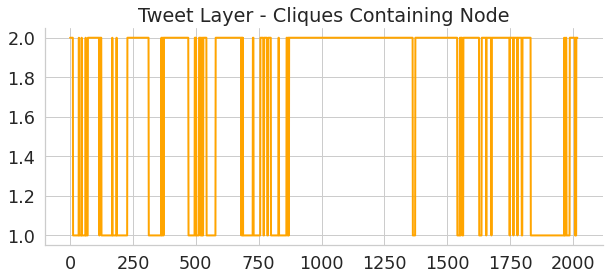

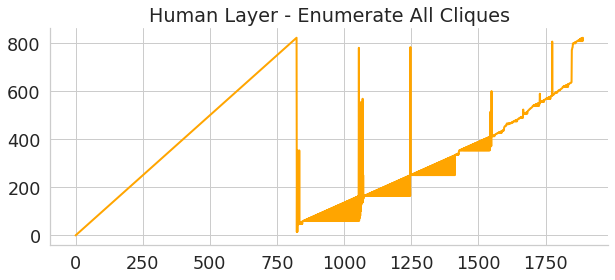

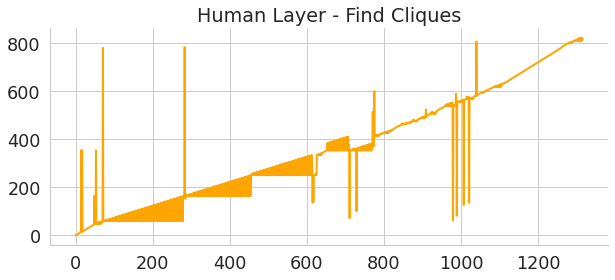

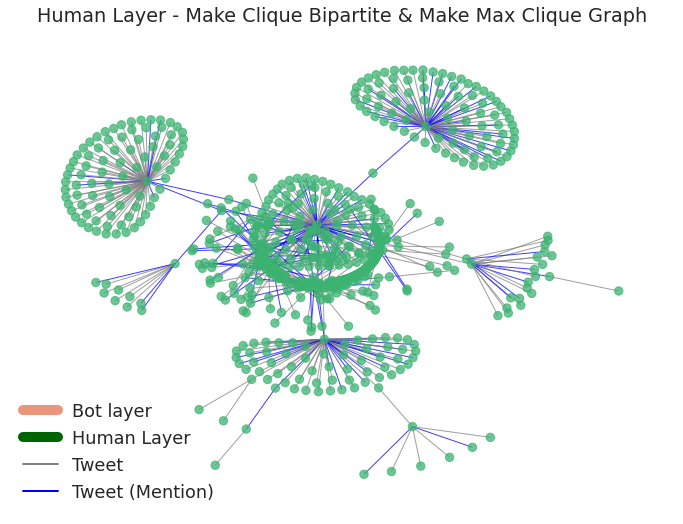

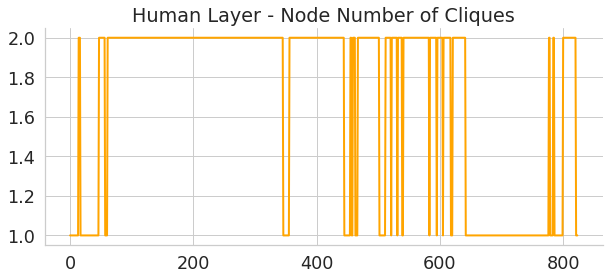

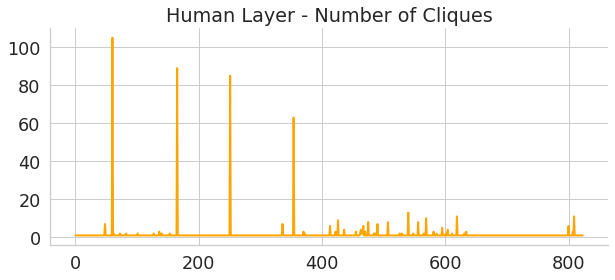

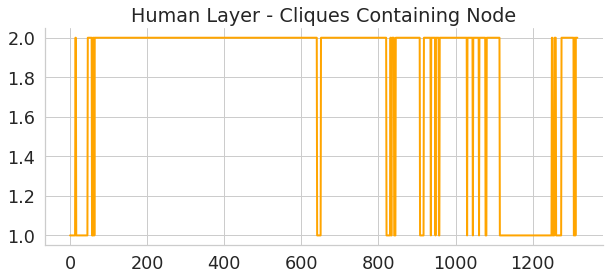

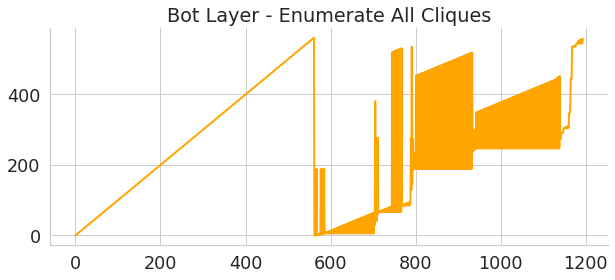

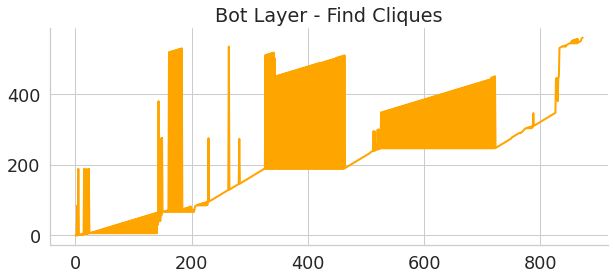

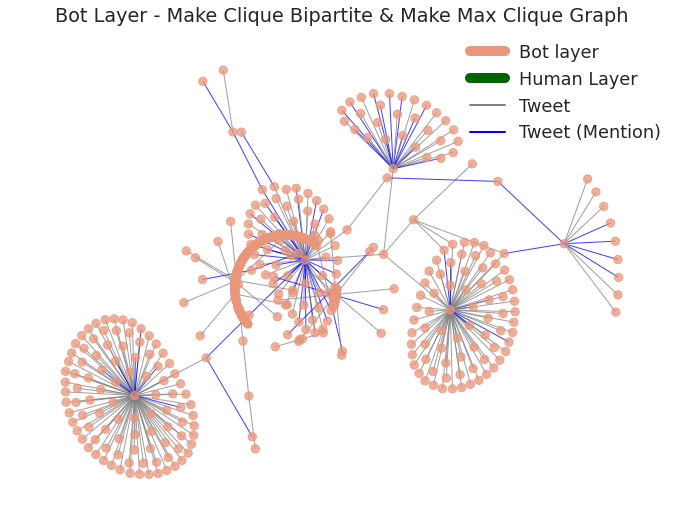

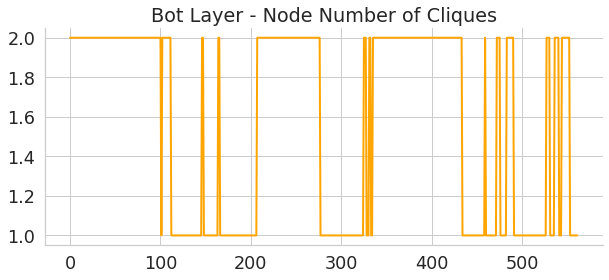

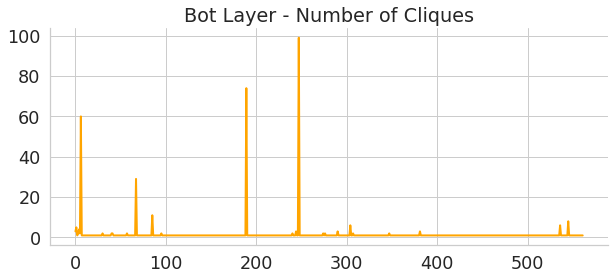

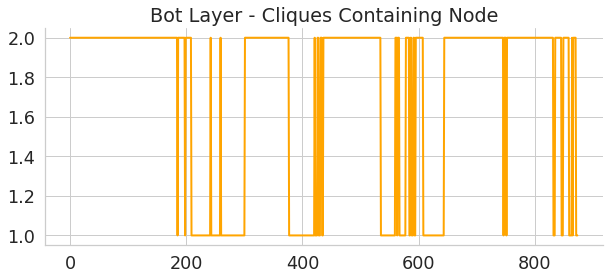

In [53]:
def runCliqueAlgos(gx, i):

    print(f"Layer: {layer_names[i]}")
    cq_data = {
         "graph_clique_number": nx.graph_clique_number(gx),
         "graph_number_of_cliques": nx.graph_number_of_cliques(gx),
         "max_weight_clique": nx.max_weight_clique(gx, weight=None)
    }

    display(cq_data)

    enumerate_all_cliques = list(nx.enumerate_all_cliques(gx))
    ecn = []
    for ec in enumerate_all_cliques:
        for ex in ec:
            ecn.append(ex)

    LinePlot(ecn, 2, f"{layer_names[i]} - Enumerate All Cliques")

    find_cliques = list(nx.find_cliques(gx))
    ecn = []
    for ec in find_cliques:
        for ex in ec:
            ecn.append(ex)

    LinePlot(ecn, 2, f"{layer_names[i]} - Find Cliques")

    G = nx.make_clique_bipartite(gx)
    cliques = [v for v in G.nodes() if G.nodes[v]['bipartite'] == 0]
    G = nx.bipartite.project(G, cliques)
    G = nx.relabel_nodes(G, {-v: v - 1 for v in G})

    sDigx = gx
      
    node_colors = list(nx.get_node_attributes(sDigx,'color').values())
    edge_colors = list(nx.get_edge_attributes(sDigx,'color').values())

    fig, ax = plt.subplots(figsize=(12, 9))
    nx.draw(sDigx, 
            pos=nx.kamada_kawai_layout(sDigx),
            # with_labels=True,
            ax=ax, 
            node_size=70, 
            node_color=node_colors, 
            edge_color=edge_colors,
            width=1.0,
            font_size=10.0,
            font_color="#002966",
            alpha=0.75)
    ax.set_title(f"{layer_names[i]} - Make Clique Bipartite & Make Max Clique Graph")
    ax.plot([0],[0],color="darksalmon",label="Bot layer", linewidth=10)
    ax.plot([0],[0],color="darkgreen",label="Human Layer", linewidth=10)
    ax.plot([0],[0],color="grey",label="Tweet", linewidth=2)
    ax.plot([0],[0],color="blue",label="Tweet (Mention)", linewidth=2)
    ax.legend(frameon=False)
    plt.savefig(f"./figures/{layer_names[i]} - Make Clique Bipartite & Make Max Clique Graph.png")




    node_clique_number = nx.node_clique_number(gx)
    ecn = []
    for ec in list(node_clique_number.values()):
        ecn.append(ec)

    LinePlot(ecn, 2, f"{layer_names[i]} - Node Number of Cliques")

    number_of_cliques = nx.number_of_cliques(gx)
    ecn = []
    for ec in list(number_of_cliques.values()):
        ecn.append(ec)

    LinePlot(ecn, 2, f"{layer_names[i]} - Number of Cliques")

    xc = nx.cliques_containing_node(gx)
    ecn = []
    for ec in list(xc.values()):
        for ex in ec:
            ecn.append(len(ex))

    LinePlot(ecn, 2, f"{layer_names[i]} - Cliques Containing Node")

    

# run all clique algos for all layers
for i, g in enumerate(graphs): 
    runCliqueAlgos(g,i)

## Node Sychronization using the Kuramoto Model
Silmulating Node Synchronization using the Kuramoto Modes

{'Tweet Layer': 0.13913487992949353, 'Human Layer': 0.11469626477693862, 'Bot Layer': 0.21408468664372202}


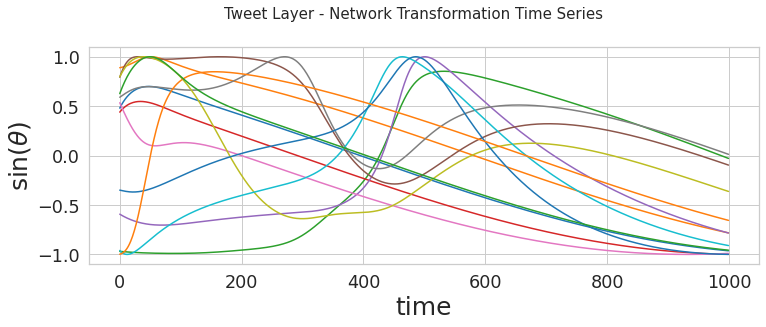

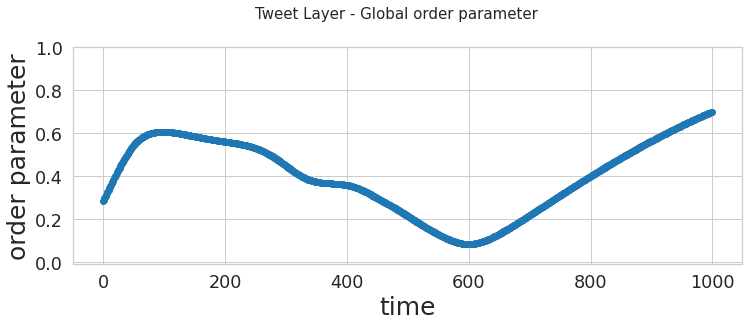

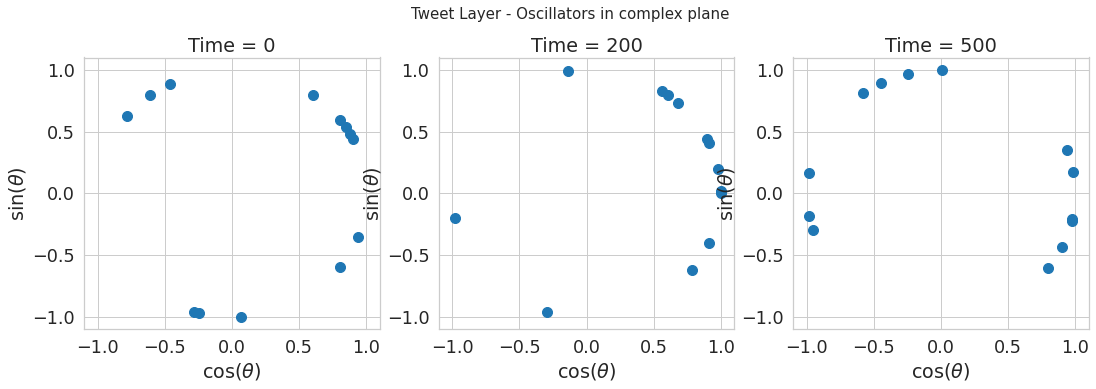

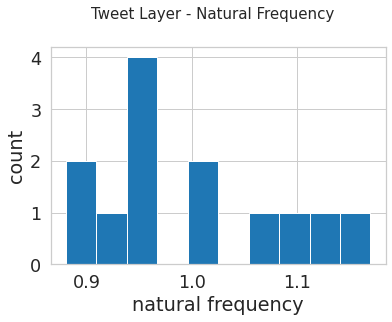

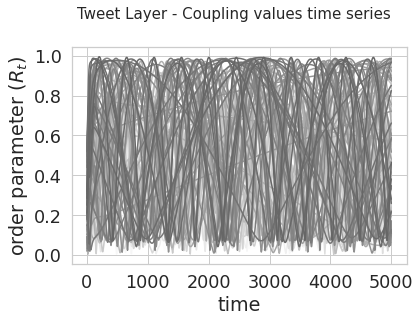

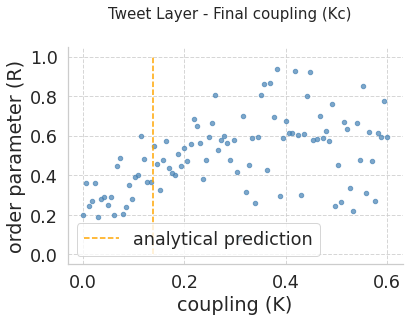

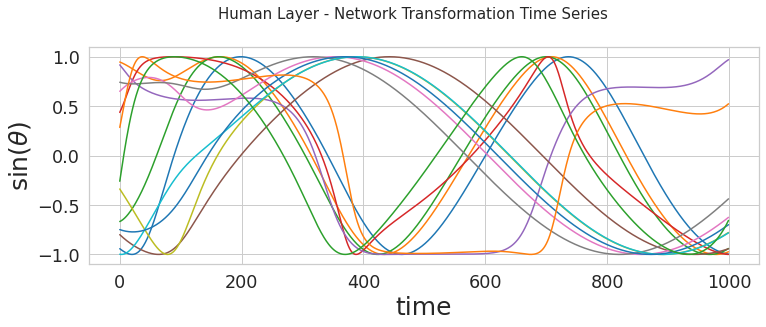

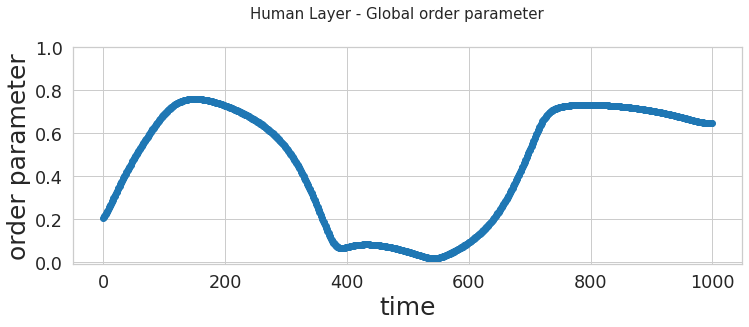

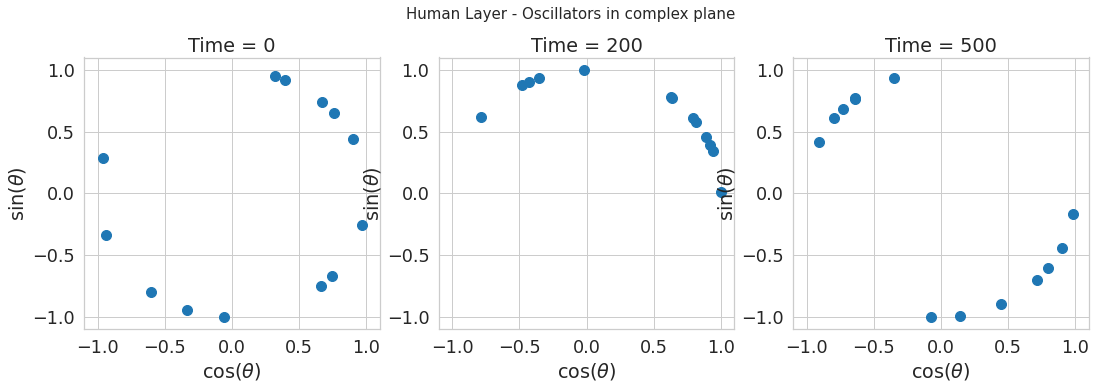

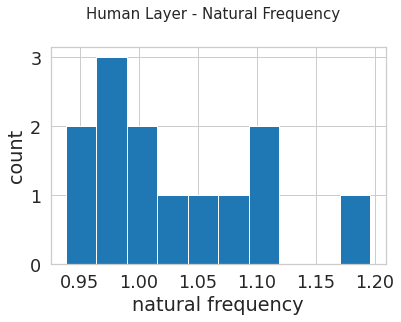

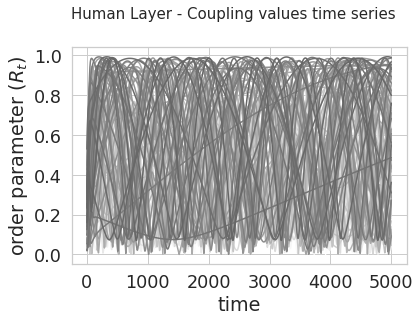

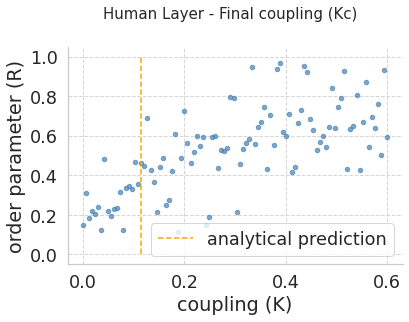

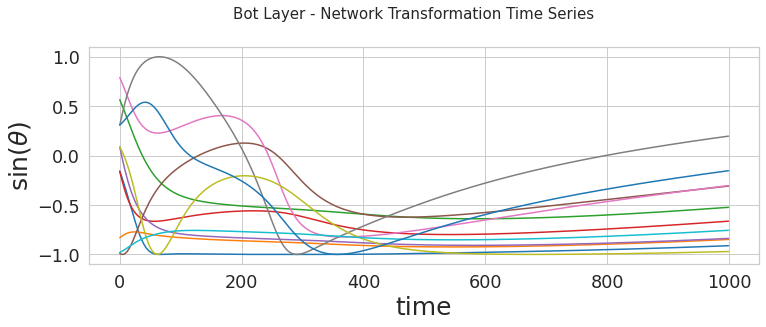

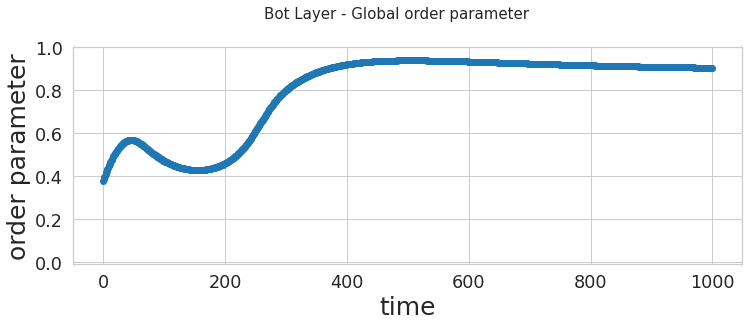

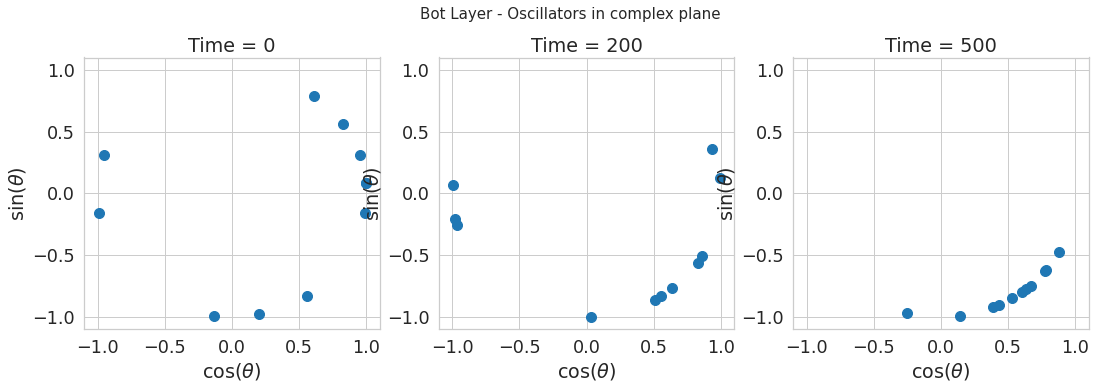

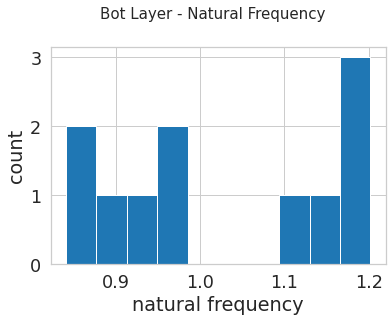

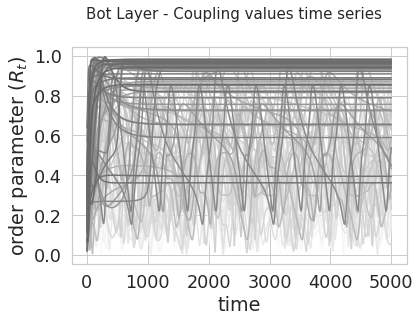

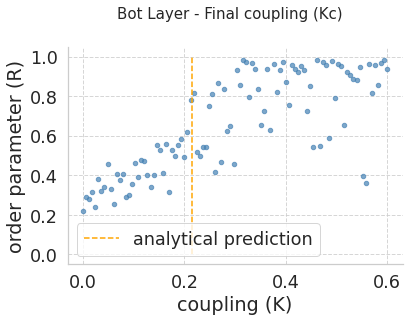

In [54]:
import seaborn as sns
from kuramoto import Kuramoto

kuramoto_results = {}

def runKuramotoModel(gx, i):
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.6)

    network_layer = layer_names[i]

    # Instantiate a random graph and transform into an adjacency matrix
    graph_nx = nx.k_core(gx)
    graph = nx.to_numpy_array(graph_nx)

    # Instantiate model with parameters
    model = Kuramoto(coupling=3, dt=0.01, T=10, n_nodes=len(graph))

    # Run simulation - output is time series for all nodes (node vs time)
    act_mat = model.run(adj_mat=graph)

    # Plot all the time series
    plt.figure(figsize=(12, 4))
    plt.plot(np.sin(act_mat.T))
    plt.xlabel('time', fontsize=25)
    plt.ylabel(r'$\sin(\theta)$', fontsize=25)
    plt.suptitle(f"{network_layer} - Network Transformation Time Series",y=1.02, fontsize=15)
    plt.savefig(f"./figures/{network_layer} - Network Transformation Time Series.png")

    # Step 2
    # Plot evolution of global order parameter R_t
    plt.figure(figsize=(12, 4))
    plt.plot(
        [Kuramoto.phase_coherence(vec)
        for vec in act_mat.T],
        'o'
    )
    plt.ylabel(f'order parameter', fontsize=25)
    plt.xlabel('time', fontsize=25)
    plt.ylim((-0.01, 1))
    plt.suptitle(f"{network_layer} - Global order parameter",y=1.02, fontsize=15)
    plt.savefig(f"./figures/{network_layer} - Global order parameter (k).png")



    # Step 3
    # Plot oscillators in complex plane at times t = 0, 250, 500
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 5),
                            subplot_kw={
                                "ylim": (-1.1, 1.1),
                                "xlim": (-1.1, 1.1),
                                "xlabel": r'$\cos(\theta)$',
                                "ylabel": r'$\sin(\theta)$',
                            })

    times = [0, 200, 500]
    for ax, time in zip(axes, times):
        ax.plot(np.cos(act_mat[:, time]),
                np.sin(act_mat[:, time]),
                'o',
                markersize=10)
        ax.set_title(f'Time = {time}')
    
    plt.suptitle(f"{network_layer} - Oscillators in complex plane",y=1.02, fontsize=15)
    plt.savefig(f"./figures/{network_layer} - Oscillators in complex plane.png")



    #Step 4

    # Run model with different coupling (K) parameters
    coupling_vals = np.linspace(0, 0.6, 100)
    runs = []
    for coupling in coupling_vals:
        model = Kuramoto(coupling=coupling, dt=0.1, T=500, n_nodes=graph_nx.number_of_nodes())
        model.natfreqs = np.random.normal(1, 0.1, size=graph_nx.number_of_nodes())  # reset natural frequencies
        act_mat = model.run(adj_mat=graph)
        runs.append(act_mat)

    # Check that natural frequencies are correct (we need them for prediction of Kc)
    plt.figure()
    plt.hist(model.natfreqs)
    plt.xlabel('natural frequency')
    plt.ylabel('count')
    plt.suptitle(f"{network_layer} - Natural Frequency",y=1.02, fontsize=15)
    plt.savefig(f"./figures/{network_layer} - Natural Frequency.png")



    # step 5
    # Plot all time series for all coupling values (color coded)
    runs_array = np.array(runs)

    plt.figure()
    for i, coupling in enumerate(coupling_vals):
        plt.plot(
            [model.phase_coherence(vec)
            for vec in runs_array[i, ::].T],
            c=str(1-coupling),  # higher -> darker   
        )
    plt.ylabel(r'order parameter ($R_t$)')
    plt.xlabel('time')
    plt.suptitle(f"{network_layer} - Coupling values time series",y=1.02, fontsize=15)
    plt.savefig(f"./figures/{network_layer} - Coupling values time series.png")



    #Step 6

    # Plot final Rt for each coupling value
    plt.figure()
    for i, coupling in enumerate(coupling_vals):
        r_mean = np.mean([model.phase_coherence(vec)
                        for vec in runs_array[i, :, -1000:].T]) # mean over last 1000 steps
        plt.scatter(coupling, r_mean, c='steelblue', s=20, alpha=0.7)

    # Predicted Kc – analytical result (from paper)
    Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs) # analytical result (from paper)

    # Save Network Kc data
    kuramoto_results[network_layer] = Kc
    
    plt.vlines(Kc, 0, 1, linestyles='--', color='orange', label='analytical prediction')

    plt.legend()
    plt.grid(linestyle='--', alpha=0.8)
    plt.ylabel(f'order parameter (R)')
    plt.xlabel(f'coupling (K)')
    sns.despine()
    plt.suptitle(f"{network_layer} - Final coupling (Kc)",y=1.02, fontsize=15)
    plt.savefig(f"./figures/{network_layer} - Final coupling (Kc).png")


        


# loop through network layers    
for i, g in enumerate(graphs):
    runKuramotoModel(g,i)

# print kuramoto Kc Coupling Results:
print(kuramoto_results)    


## Chaos in the Network (Generate Values)
Generate and print out values for visualizing chaos
for
1. Covid & Monkey


## Visualizing Chaos (Animations)
Frame by Frame animation similar to (Method comparison), save images on a folder.
1. Covid & Monkeypox
2. Extension of Kuramoto Model
3. Lorenz Attractor Model / Animation
4. Explore if possible to save animations frame by frame

### Animation Reference
https://youtu.be/XBLC0DaJvhA

## Implementing Density, Eigen Decomposition, EigenStates
implement parsing of Research concepts to network data. To calculate density, the combination of both the humany layer nodes and bot layer nodes which will be represented by the tweets layer will be converted into a matrix, (adjecency matrix) and then the calculations will be applied for `density` and `eigen decomposition`

In [55]:
# reconstruct matrix
from numpy import diag
from numpy import dot
from numpy.linalg import inv
from numpy import array
from numpy.linalg import eig


# get combined layer data
Gmx = nx.k_core(graphs[0])

# network_density
Dgx = nx.density(Gmx)

# network matrix
Nmx = nx.adjacency_matrix(Gmx).toarray()

values, vectors = eig(Nmx)
# create matrix from eigenvectors
Q = vectors
# create inverse of eigenvectors matrix
R = inv(Q)
# create diagonal matrix from eigenvalues
L = diag(values)
# reconstruct the original matrix
# eigen decomposition
eigenDecomposition = Q.dot(L).dot(R)

# calculate enigenstates


print("eigenDecomposition:")
print(eigenDecomposition)
print("Network Density:",Dgx)


eigenDecomposition:
[[ 3.33066907e-16+6.44956302e-34j  1.00000000e+00-4.74602832e-18j
  -3.82338729e-31-1.14747434e-18j  6.10622664e-16+2.07809967e-17j
  -3.05594581e-17-9.28043212e-18j  5.55111512e-17+4.16819760e-18j
   1.00000000e+00+7.20628318e-18j -3.05594581e-17-4.40286113e-18j
   8.04628443e-17+4.40286113e-18j  8.04628443e-17+8.65966197e-19j
  -2.63285835e-31+3.30768886e-18j  6.10622664e-16+6.49495544e-19j
   5.55111512e-16+3.40459047e-18j]
 [ 1.00000000e+00+2.11469590e-33j  1.39434125e-16-1.10836886e-16j
   2.44841740e-16-8.08023090e-18j  1.00000000e+00-5.31951998e-17j
   1.88238341e-16+6.29243990e-17j -1.72817916e-16+3.07949273e-19j
   7.29695879e-16+1.07589619e-16j  3.92254571e-16+6.26038210e-17j
  -4.43458073e-16-6.26038210e-17j -1.97700328e-16-9.59487772e-17j
  -4.76000284e-18-8.80449732e-17j  1.00000000e+00+7.02605059e-18j
   1.00000000e+00+2.27958658e-17j]
 [ 8.75306203e-33-5.61540106e-33j  7.17293546e-16-1.82703764e-16j
   5.89410524e-16+1.73631265e-16j  2.81423567e-18-2.

## Potential energy drop (Line Graph)
- 1 Line Graph
- Arrange the array from highest to lowest
- Axis 1 - Covid 19
- Axis 2 - MonkeyPox
- Use Data from eigenDecomposition

## Kinetic Engery discharge at the edges of nodes
- Linegraph
- Linear Interpolation
- 2 axis for Covid19 and MonkeyPox
- Data from eigen decomposition
- No ordering from the array

In [56]:
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal

## Application of Time Independent Schrodinger Equations, Finite Difference, EigenStates

1.	Graph wavefunction using the Time Independent Schrodinger Equation (this serves as a generic model) See “EDIT” for the correction. Refer to the definitions here. 
2.	Graph based on Finite Difference and Eigenstate Evolution.
3.	Graph based on Eigenstates.

The Time Dependent Schrodinger Equation (in a position basis with infinite boundaries) is 

$$ i \hbar \frac{\partial}{\partial t} \psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi(x,t) + V(x) \psi(x,t) \hspace{20mm} \psi(0, t) = \psi(L,t)=0 $$

We don't need to deal with extra parameters like $m$, $\hbar$, etc. Multiplying both sides by $mL^2$ where $L$ is the characteristic length of the problem (here we are bounded in length $L$)

$$ i mL^2 \hbar \frac{\partial}{\partial t} \psi = -\frac{1}{2}\hbar^2 L^2\frac{\partial^2}{\partial x^2}\psi + mL^2V(x) \psi $$

Now choose the convention $\hbar=1$ (So Joules=1/Seconds) and make the transformation

* $x'=\frac{x}{L}$
* $t' = \frac{t}{mL^2}$
* $V' = mL^2V$

You can check that with the convention $\hbar=1$, all of the three quantities above are dimensionless. The Schrodinger equation with respect to these three variables becomes

$$ i \frac{\partial}{\partial t'} \psi = -\frac{1}{2}\frac{\partial^2}{\partial x'^2}\psi + V'(x) \psi $$

We solve this equation for $x'$ and $t'$ and then solve for $x$ and $t$ using 

* $x = Lx'$
* $t = (mL^2) t'$
* $V = (mL^2)^{-1} V'$

**For all the numerical work we will drop the primes on $x'$, $t'$, and $V'$ but know that we are working with the primed quantities**

In [57]:
# Network Calculation
Nx = graphs[0].number_of_nodes()

Nt = 100000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)

# step 2

Nt = 100000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)
mu, sigma = 1/2, 1/20
V = -1e4*np.exp(-(x-mu)**2/(2*sigma**2))


Look at $dt/dx^2$ (this parameter should be small for the finite difference method to work).

In [58]:
dt/dx**2

0.18851289999999998

The (dimensionless) potential we examine here is

$$V(x) = -10^4 \exp{\left(\frac{-(x-L/2)^2}{2(L/20)^2}\right)}$$

which is essentially just a normal curve which can be specified more simply as $V(x) = -n(x, \mu=L/2, \sigma=L/20)$

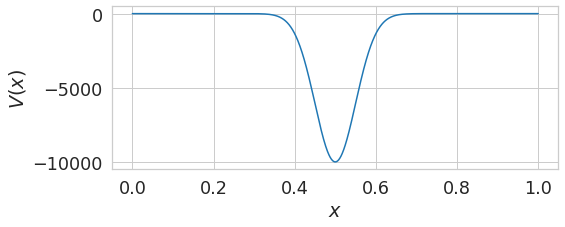

In [59]:
plt.figure(figsize=(8,3))
plt.plot(x,V)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.savefig(f"./figures/Network Dimentionless potential.png")


[[ 0.00000000e+00+0.00000000e+00j  3.23589152e-03+0.00000000e+00j
   6.47176610e-03+0.00000000e+00j ...  6.47176610e-03+0.00000000e+00j
   3.23589152e-03+0.00000000e+00j  1.73191211e-16+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  3.23589096e-03-1.59684748e-09j
   6.47176497e-03-3.19368661e-09j ...  6.47176497e-03-3.19368661e-09j
   3.23589096e-03-1.59684749e-09j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  3.23589096e-03-3.19369497e-09j
   6.47176497e-03-6.38737322e-09j ...  6.47176497e-03-6.38737322e-09j
   3.23589096e-03-3.19369499e-09j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j -1.97083836e-03-1.11202116e-02j
   3.94466865e-03+2.22377970e-02j ... -1.98831049e-02-1.82022769e-03j
   9.94412827e-03+9.10697027e-04j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -5.76695665e-03-9.70972859e-03j
   1.15357864e-02+1.94159446e-02j ... -1.92467371e-02+5.31037552e-03j
   9.62598447e-03-2.65555055e-03j  0.00000000e+

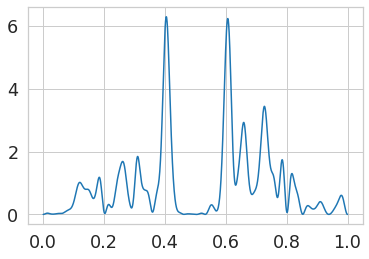

In [60]:

psi = np.zeros([Nt,Nx])
psi[0] = psi0

@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dt*V[i]*psi[t][i]
        
        normal = np.sum(np.absolute(psi[t+1])**2)*dx
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t+1][i]/normal
        
    return psi

psi_m1 = compute_psi(psi.astype(complex))

print(psi_m1)

plt.plot(x, np.absolute(psi_m1[5000])**2)
plt.savefig(f"./figures/Network potential.png")

#np.sum(np.absolute(psi_m1[10000])**2)*dx

## Caclulate EigenStates

[0.00000000e+00 1.04709940e-05 4.18837569e-05 ... 4.18837569e-05
 1.04709940e-05 0.00000000e+00]


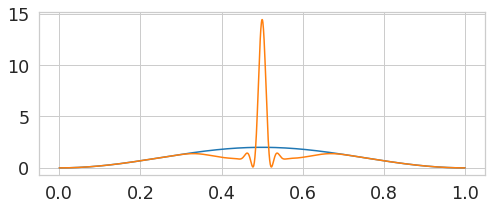

In [61]:
dx = 1/(Nx-1)
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)

def V(x):
    mu, sigma = 1/2, 1/20
    return -1e4*np.exp(-(x-1/2)**2/(2*(1/20)**2))

d = 1/dx**2 + V(x)[1:-1]
e = -1/(2*dx**2) * np.ones(len(d)-1)
w, v = eigh_tridiagonal(d, e)


# step

E_js = w[0:70]
psi_js = np.pad(v.T[0:70], [(0, 0), (1, 1)], mode='constant')
cs = np.dot(psi_js, psi0)
def psi_m2(t):
    return psi_js.T@(cs*np.exp(-1j*E_js*t))

plt.figure(figsize=(8,3))
plt.plot(x, psi0**2)
plt.plot(x, np.absolute(psi_m2(10000*dt))**2)
plt.savefig(f"./figures/Compute Eigen states - t2.png")

exgs =  np.absolute(psi_m2(10000*dt))**2
print(exgs)

## Method comparison (Method 1 & Method 2)
- Method 1 : Finite Difference
- Method 2 : Eigenstate Evolution

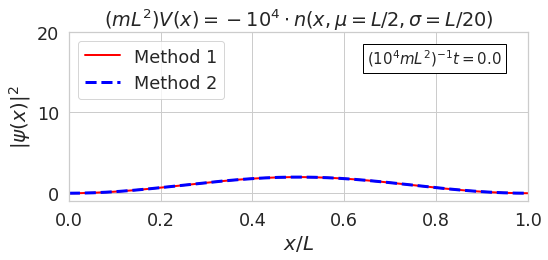

In [62]:
def animate(i):
    ln1.set_data(x, np.absolute(psi_m1[100*i])**2)
    ln2.set_data(x, np.absolute(psi_m2(100*i*dt))**2)
    time_text.set_text('$(10^4 mL^2)^{-1}t=$'+'{:.1f}'.format(100*i*dt*1e4))
    plt.savefig(f"./figures/method_comparison/{i+1}.png")
    
fig, ax = plt.subplots(1,1, figsize=(8,4))
#ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Method 1')
ln2, = plt.plot([], [], 'b--', lw=3, markersize=8, label='Method 2')
time_text = ax.text(0.65, 16, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 20)
ax.set_xlim(0,1)
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x/L$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('./figures/method-comp-anim.gif',writer='pillow',fps=50,dpi=100)

## Mass and Energy Projection
Compton Scattering, 
1. Youtube: https://youtu.be/BJUasLU9rCY
2. Check PDF to replace values

### Visualize Line graphs, 2 axis, for covid and monkeypox respectively

## Plot Eigenstates
Plotting Eigen States

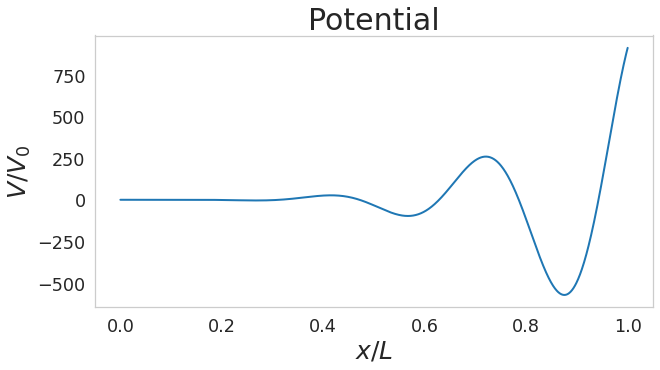

In [63]:
from scipy.linalg import eigh_tridiagonal

# step 1
N = Nx
dy = 1/N
y = np.linspace(0, 1, N+1)

#step 2
def mL2V(y):
    return 1000*np.sin(20*y) * y**4 
d = 1/dy**2 + mL2V(y)[1:-1]
e = -1/(2*dy**2) * np.ones(len(d)-1)   
w, v = eigh_tridiagonal(d, e)

plt.figure(figsize=(10,5))
plt.plot(y, mL2V(y), lw=2)
plt.title('Potential', fontsize=30)
plt.ylabel('$V/V_0$', fontsize=25)
plt.xlabel('$x/L$', fontsize=25)
plt.grid()
plt.savefig('./figures/eigenstates potential.png', dpi=200)


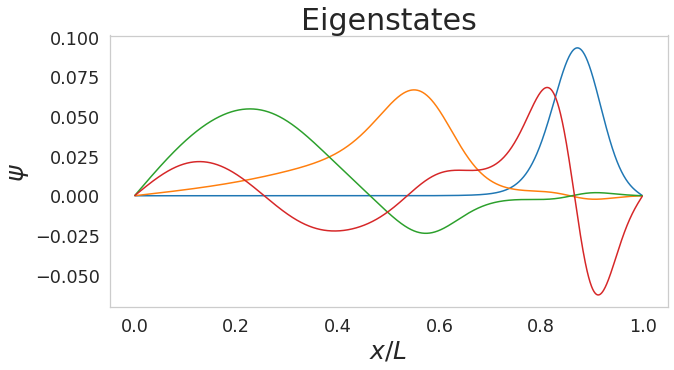

In [64]:
plt.figure(figsize=(10,5))
plt.plot(y[1:-1], v.T[0])
plt.plot(y[1:-1], v.T[1])
plt.plot(y[1:-1], v.T[2])
plt.plot(y[1:-1], v.T[3])
plt.title('Eigenstates', fontsize=30)
plt.ylabel('$\psi$', fontsize=25)
plt.xlabel('$x/L$', fontsize=25)
plt.grid()
plt.savefig('./figures/eigenstates plot.png', dpi=200)

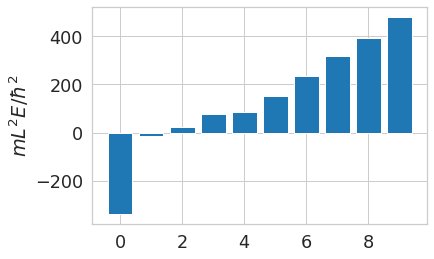

In [65]:
plt.bar(np.arange(0, 10, 1), w[0:10])
plt.ylabel('$mL^2 E/\hbar^2$')
plt.savefig('./figures/eigenstates bar plot.png', dpi=200)

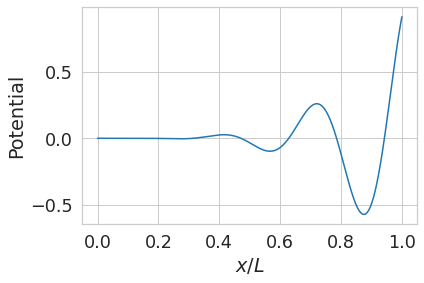

In [66]:
x = np.linspace(0, 1, 1000)
y = np.sin(20*x) * x**4 

plt.plot(x, y)
plt.xlabel('$x/L$')
plt.ylabel('Potential')
plt.savefig('./figures/eigenstates-potential.png', dpi=200)

## Final Calculations / Visualizations
- a.	Use eigenvalues to calculate von Neumann Graph Entropy.
- b.	Use eigenvalues to calculate Network Density of States.
- c.	Use eigenvalues to simulate gravitational waves (m1 = lowest eigenvalue; m2= highest eigenvalue)

## Von Neumann Graph Entropy


In [67]:
# # Name: VNGE
# Author: Reacubeth
# Time: 2021/1/25 16:01
# Mail: noverfitting@gmail.com
# Site: www.omegaxyz.com
# *_*coding:utf-8 *_*

import time
from scipy.sparse.linalg import eigsh


def normalized_laplacian(adj_matrix):
    nodes_degree = np.sum(adj_matrix, axis=1)
    nodes_degree_sqrt = 1/np.sqrt(nodes_degree)
    degree_matrix = np.diag(nodes_degree_sqrt)
    eye_matrix = np.eye(adj_matrix.shape[0])
    return eye_matrix - degree_matrix * adj_matrix * degree_matrix


def unnormalized_laplacian(adj_matrix):
    nodes_degree = np.sum(adj_matrix, axis=1)
    degree_matrix = np.diag(nodes_degree)
    return degree_matrix - adj_matrix



def VNGE_exact(adj_matrix):
    start = time.time()
    nodes_degree = np.sum(adj_matrix, axis=1)
    c = 1.0 / np.sum(nodes_degree)
    laplacian_matrix = c * unnormalized_laplacian(adj_matrix)
    eigenvalues, _ = np.linalg.eig(laplacian_matrix)
    eigenvalues[eigenvalues < 0] = 0
    pos = eigenvalues > 0
    H_vn = - np.sum(eigenvalues[pos] * np.log2(eigenvalues[pos]))
    return H_vn


def VNGE_FINGER(adj_matrix):
    start = time.time()
    nodes_degree = np.sum(adj_matrix, axis=1)
    c = 1.0 / np.sum(nodes_degree)
    edge_weights = 1.0 * adj_matrix[np.nonzero(adj_matrix)]
    approx = 1.0 - np.square(c) * (np.sum(np.square(nodes_degree)) + np.sum(np.square(edge_weights)))
    laplacian_matrix = unnormalized_laplacian(adj_matrix)
    '''
    eigenvalues, _ = np.linalg.eig(laplacian_matrix)  # the biggest reduction
    eig_max = c * max(eigenvalues)
    '''
    eig_max, _ = eigsh(laplacian_matrix, 1, which='LM')
    eig_max = eig_max[0] * c
    H_vn = - approx * np.log2(eig_max)
    print('H_vn approx:', H_vn)
    print('Time:', time.time() - start)


Nmx = Nmx.astype(float)

# evolution of von neumann graph entropy
envge = VNGE_exact(Nmx)
print("Von Neumman Graph Entropy Exact: ", envge)
VNGE_FINGER(Nmx)

Von Neumman Graph Entropy Exact:  3.254892110851873
H_vn approx: 2.1320252923321044
Time: 0.0037949085235595703


## Implementing Research Equations
Implementation of research equations from the values of network statistics

Equations
- Bot Mass - Done
- Bot energy
- Energy Fluctuations
- Virality of bots

Calculating Bot Mass:
Number of Interactions bet bots and human users: 693
Number of False Tweets: 316
Network Density: 0.000734693098655607
Constant: 3.1899999999999996e-38
 
Calculating Bot Energy:
Bot Mass: 9.508347380399999e-30
Kuramoto Coupling: 0.13913487992949353
Matrix_power: [8.43509773e-28] ...
Speed of light squared: 8.98755179e+16
 
Calculating Energy in Network:
Von Neumann Graph Entropy: 3.254892110851873
Evolution of Eigenstates: [0.00000000e+00 1.04709940e-05 4.18837569e-05 ... 4.18837569e-05
 1.04709940e-05 0.00000000e+00]
kb constant: 4.14192e-21
ln2 constant: 0.69314718055995
 
Calculating Virality of Bots:
Bot Energy <class 'numpy.ndarray'> ...
Energy in Network [0.00000000e+00 8.92433475e-16 2.23109537e-16 ... 2.23109537e-16
 8.92433475e-16 0.00000000e+00] ...
 
 
Results:
Bot mass:  9.508347380399999e-30
Bot Energy (Averaged Value):  1.5759548722984758e-13
Energy In Network (Averaged Value):  2.1384774566373422e-18
Virality of Bots:  0.7278106508875738


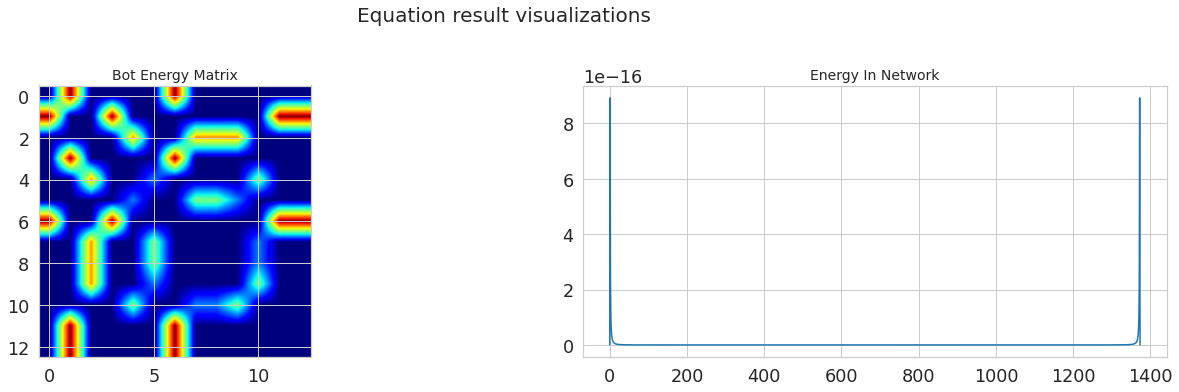

In [68]:
from numpy.linalg import matrix_power

# Equation 1: Bot Mass
interactions = graphs[0].number_of_edges()
false_tweets = graphs[2].number_of_edges()
network_density = nx.density(graphs[0])
cmtx = 3.19*10**-38

print("Calculating Bot Mass:")
print("Number of Interactions bet bots and human users:", interactions)
print("Number of False Tweets:", false_tweets)
print("Network Density:", network_density)
print("Constant:", cmtx)

bm =((interactions*false_tweets)/network_density)*cmtx

print(" ")

# Equation 2: Bot Energy
kcp = kuramoto_results["Tweet Layer"]
matrix_power_ev = matrix_power(eigenDecomposition, 3)
speed_of_light_squared = 8.98755179*10**16


be = bm*(kcp*matrix_power_ev)*speed_of_light_squared
be = be.real
np.savetxt('bot_energy.txt', be, delimiter=',')

print("Calculating Bot Energy:")
print("Bot Mass:", bm)
print("Kuramoto Coupling:", kcp)
print("Matrix_power:", (np.matrix.flatten(be)[0:1]),"...")
print("Speed of light squared:", speed_of_light_squared)

print(" ")


print("Calculating Energy in Network:")
# Equation 3: Energy fluctuations
evolution_vnge = envge
evolution_eigenstates = exgs.real
constant_kb = (1.38064*10**-23)*(300)
constant_ln2 = 0.69314718055995

print("Von Neumann Graph Entropy:",evolution_vnge)
print("Evolution of Eigenstates:",evolution_eigenstates)
print("kb constant:", constant_kb)
print("ln2 constant:", constant_ln2)

efx = (envge / exgs)*constant_kb*constant_ln2
# set infinite values to zero
efx[efx >= 1E308] = 0
efx[np.isnan(efx)] = 0
efx = efx.real

print(" ")

# Equation 4: Virality of Bots
print("Calculating Virality of Bots:")

print("Bot Energy",type(be),"...")
print("Energy in Network",efx,"...")


vob = be**(np.average(efx))
vob[np.isnan(vob)] = 0
vob = np.average(vob)



print(" ")
print(" ")
print("===================================================================")
print("Results:")

# show results
print("Bot mass: ", bm)
print("Bot Energy (Averaged Value): ", np.average(np.matrix.flatten(be)))
print("Energy In Network (Averaged Value): ",np.average(efx))
print("Virality of Bots: ",vob)

# matrix visualizations
fig, all_axes = plt.subplots(1, 2, figsize=(23,5))
ax = all_axes.flat
fig.suptitle("Equation result visualizations",y=1.1, fontsize=20)

# compute the best partition
ax[0].set_title(f"Bot Energy Matrix", fontsize=14)
ax[0].imshow(be, cmap="jet", interpolation="bilinear")

ax[1].set_title(f"Energy In Network", fontsize=14)
ax[1].plot(efx)



plt.savefig("./figures/matrix_visualizations.png")



## Energy in the Network - Logarithmic
- Using array for Bot Energy data (Research Equations)
- Line Graph -> Scatter Line / Smooth Interpolation
- 2 axis - Monkey pox and Covid 19

## Final visualizations
This visualizaton will cover a heatmap spectral plot of the eigenvalues and eigenvectors to show how much effect
The first step of this final codeblock is to make sure that the data for network can be layed out, with all the nodes and their medata

## Plotting Node influence with Timeseries using Heatmap
This method of visualization for the node influence is the best way of showing the influence of the node in relation time that the tweets occured

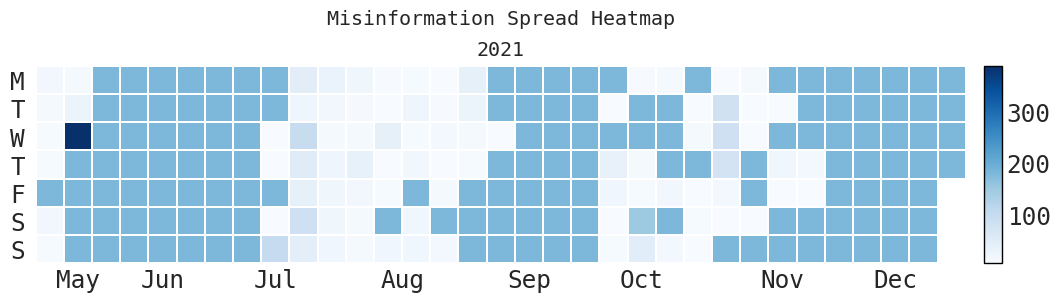

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import july
from july.utils import date_range
import moment



network_timeseries = {}
network_node_classifications = {}

# create network timeseries data

for index, row in input_data[range_start:range_end].iterrows():
    tweet_date = moment.date(row["tweet_created_at"]).format("YYYY-MM-DD")

    if tweet_date not in network_timeseries:
       network_timeseries[tweet_date] = 5
    else:
       network_timeseries[tweet_date] += 1

    bot_type = ""   

    if row["from_user_type"] == "bot":
       network_timeseries[tweet_date] += 1
       bot_type = row["from_user_bot_type"]
    else:
       bot_type = "false (human account)"   

       

    node_item = {
        "id": index,
        "username": row["from_user_screen_name"],
        "bot_type": bot_type,
        "user_type": row["from_user_type"],
        "origin_tweet_date": tweet_date,
        "degree": network_timeseries[tweet_date], 
        "tweet_url": row["tweet_url"]
    }

    if row["from_user_screen_name"] not in network_node_classifications:
       network_node_classifications[row["from_user_screen_name"]] = node_item
    else:   
       network_node_classifications[row["from_user_screen_name"]]["degree"] += network_timeseries[tweet_date]

   
# sort entries
sorted(network_timeseries.keys())
     

# print(network_timeseries)

tsl = list(network_timeseries.keys())

start_date = tsl[0]
end_year = moment.date(tsl[len(tsl)-1]).format("YYYY")

dates = date_range(start_date, f"{end_year}-12-30")
data = np.random.randint(0, 1, len(dates))

timeframe_data = {}

for date in dates:
   dx = moment.date(date).format("YYYY-MM-DD")
   timeframe_data[dx] = 180

for dx in list(network_timeseries.keys()): 
   timeframe_data[dx] = network_timeseries[dx]


july.heatmap(dates, list(timeframe_data.values()), title='Misinformation Spread Heatmap', colorbar=True, cmap="Blues", fontsize=12)
plt.savefig("./figures/misinformation_heatmap.png")

## Tabular Representation of the Most Influential users / Nodes
This is the final formal component of the paper implementation, all the accounts listed below are the most influential accounts/nodes in the infodemic network from twitter. 

In [70]:
# preprocess node network classifications
network_node_classifications = list(network_node_classifications.values())
# sort by degree descending order
network_node_classifications = sorted(network_node_classifications, key = lambda i: i['degree'],reverse=True)

mib_table = pd.DataFrame(network_node_classifications)
display(mib_table)
mib_table.to_csv("./dataset/most_influential_users.csv")

id         username               bot_type user_type origin_tweet_date  \
0   978          newsmax                spammer       bot        2021-05-26   
1   434  JonPort79449036  false (human account)     human        2021-10-09   
2   308       nickisnest  false (human account)     human        2021-08-13   
3   591        CobyJay41  false (human account)     human        2021-08-11   
4   155           bev768  false (human account)     human        2021-10-07   
..  ...              ...                    ...       ...               ...   
90  867         Sbartol3  false (human account)     human        2021-05-26   
91  887     SmithMEGA007  false (human account)     human        2021-07-15   
92  733       sgibbsters  false (human account)     human        2021-08-16   
93  917  CrashingJustice  false (human account)     human        2021-05-23   
94  848  DonnaOw66990971  false (human account)     human        2021-05-24   

    degree                                          tweet_url  
0    34672  https://twitter.com/newsmax/status/13975977479...  
1    15721  https://twitter.com/JonPort79449036/status/144...  
2     2881  https://twitter.com/nickisnest/status/14260638...  
3     2473  https://twitter.com/CobyJay41/status/142556404...  
4     2285  https://twitter.com/bev768/status/144620171511...  
..     ...                                                ...  
90      11  https://twitter.com/Sbartol3/status/1397380162...  
91      10  https://twitter.com/SmithMEGA007/status/141555...  
92       9  https://twitter.com/sgibbsters/status/14272429...  
93       9  https://twitter.com/CrashingJustice/status/139...  
94       5  https://twitter.com/DonnaOw66990971/status/139...  

[95 rows x 7 columns]

## Plotting Spectrogram
- Extend Simulation time to 5 days

[ 0.00296165  0.82279018  1.15723726 ... -0.2256043  -0.26354054
 -0.06476528]


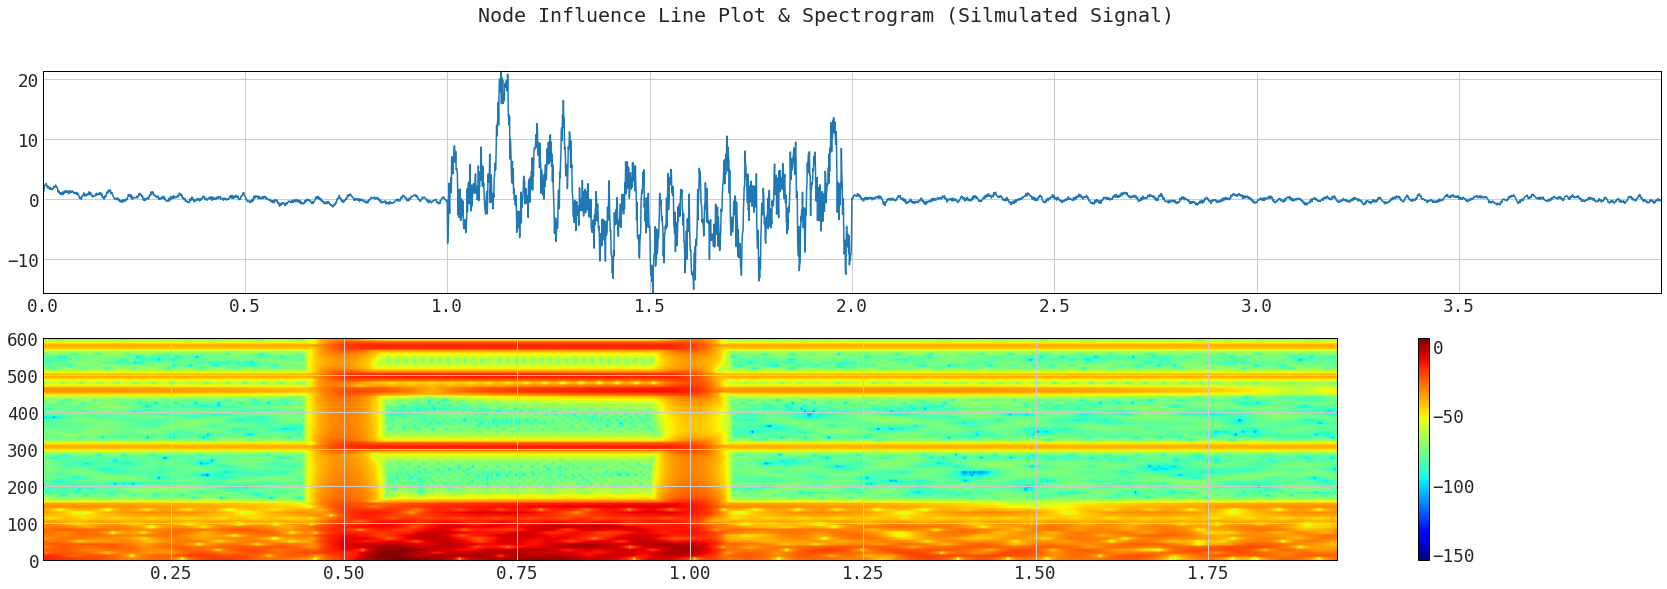

In [71]:
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import specgram
from scipy.io.wavfile import write


dt = 0.001
t = np.arange(0.0, 4.0, dt)
s1 = np.sin(2*np.pi*20*t)
s2 = 3*np.sin(1.2*np.pi*20*t)
mask = np.where(np.logical_and(t>1, t<2), 2.0, 0.0)
s2 = s2 * mask
nse = 0.004*np.random.randn(len(t))

for i,x in enumerate(s1):
    s1[i] = 0.00 
x = nse


for i, xt in enumerate(network_node_classifications):
    if(xt["degree"] > 0):
        x += 2*np.sin((xt["degree"]*0.01)*np.pi*20*t) * np.where(np.logical_and(t>1, t<2), 0.5, 0.03)
    else: 
        x += 1*np.sin((i*0.0004)*np.pi*20*t)

NFFT = 256      # the length of the windowing segments
Fs = int(2.0/dt)  # the sampling frequency

# Generate Audio File from Signal

data = x 
data.astype(int)
print(data)
scaled = np.int16(data/np.max(np.abs(data)) * 1152767)
write('./dataset/spectrogram_audio.wav', len(data), scaled)



plt.figure(figsize=(29,9))
plt.subplot(211)
plt.plot(t, x)
plt.suptitle("Node Influence Line Plot & Spectrogram (Silmulated Signal)", fontsize=20)
ax1 = plt.subplot(212)
Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=255, cmap="jet")
ax1.set_ylim((0,600))
plt.colorbar()
plt.savefig("./figures/node_influence_spectrogram.png")

The spectrogram above is a simulated signal to show each node / twitter account's degree of influence, which is based on the degress of connections of bot users within the network. A signal can be resource intensive to implement, the time domain of the signal is simulated and is not based on the actual timeframe of the tweets / connections in the network.

## Bot Energy + Network Energy
1. Get data from Audion file "spectrogram_audio.wav"
2. Get Frequency of the Audio file in Hz
3. Convert Hz to Joules, each point of frequency is divided by constant 1.50919031167677E+33 Hz
4. Values of bot_energy.text is combined with array in no. 3
5. Sort the array from lowest to highest
6. add logarithm to Y Axis, resulting aaray from no. 5

## Wavelet Transform 
- Implement Wavelet Transform for the simulated signal

## Power Spectral Analysis
- Visualize Signal strength
- Power / Spectral Chart
- Removing the Noise from the Signal
- Use data from spectrogram

### Visualize Generated Audio File (Spectrogram)
Generate Another Plot for the Generated Audio File from simulated signal of the spectrogram

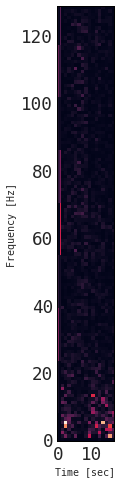

<Figure size 432x288 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('./dataset/spectrogram_audio.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.figure(figsize=(4,8))
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.gca().invert_yaxis()
plt.show()
plt.savefig("./figures/audio_generated_spectrogram.png")

## [Final] Visualize Sonification for Each Tweet type
1. Create an audio file for each simulated Bot Tweet Type
2. Visualize audio signal from each audio files
3. Graph each signal for each Bot type
4. Generate intervals for the Geiger Counter ticks

## Additional Network Analysis
Implementation of Additional steps for network analysis The Implementation will cover the following:
- Percolation Centrality Per node
- Page Rank per node
- Random Walk per node

> Note: the "Clique Maximum weight per node" is not included because it is not supported by networkx.

In [73]:
import random
import operator

# get target graph network
tnx = graphs[0]

pagerank = nx.pagerank(tnx, max_iter=100)
bc_tnx = nx.betweenness_centrality(tnx)
evc_tnx = nx.eigenvector_centrality(tnx, max_iter=600)
ncn_tnx = nx.node_clique_number(tnx)
cfcc_tnx = nx.closeness_centrality(tnx)

pagerank_dx = {}
bc_tnx_dx = {}
evc_tnx_dx = {}
ne_dx = {}
pc_dx = {}
ncn_dx = {} 
cfcc_dx = {}


# parse centrality values to fit format for tabulation

for i,x in enumerate(pagerank.values()):
    pagerank_dx[i] = {"page_rank":x}

for i,x in enumerate(bc_tnx.values()):
    bc_tnx_dx[i] = {"betweenness_centrality":x}

for i,x in enumerate(evc_tnx.values()):
    evc_tnx_dx[i] = {"eigenvector_centrality":x}    

for i,x in enumerate(NE_mid.values()):
    ne_dx[i] = {"node_entanglement":x}

for i,x in enumerate(ncn_tnx.values()):
    ncn_dx[i] = {"clique_number":x}

for i,x in enumerate(cfcc_tnx.values()):
    cfcc_dx[i] = {"closeness_centrality":x}


# set algorithm results as node attribute for tabulation
nx.set_node_attributes(tnx, pagerank_dx)
nx.set_node_attributes(tnx, bc_tnx_dx)
nx.set_node_attributes(tnx, evc_tnx_dx)
nx.set_node_attributes(tnx, ne_dx)
nx.set_node_attributes(tnx, ncn_dx)
nx.set_node_attributes(tnx, cfcc_dx)


percolation_cx = nx.percolation_centrality(tnx, attribute="page_rank")

# parse percolation values

for i,x in enumerate(percolation_cx.values()):
    pc_dx[i] = {"percolation_centrality":x}

nx.set_node_attributes(tnx, pc_dx)

### Visualizing Percolation Centrality
Generated Tables and Graphs based on available data

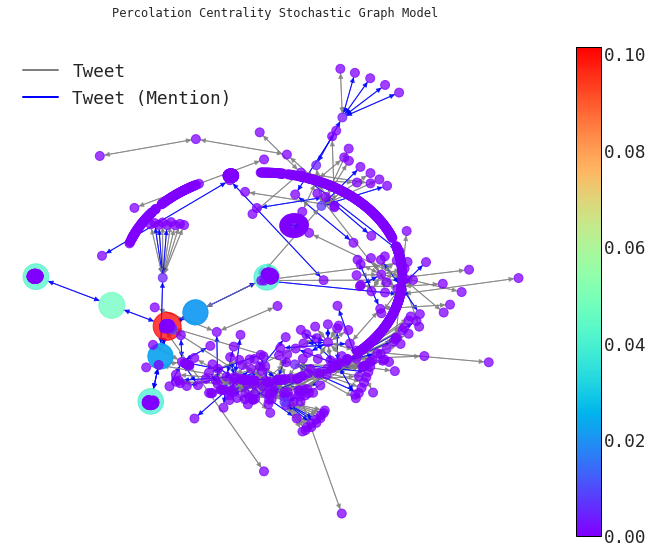

In [74]:
def customizeNodesize(value):
    def_size = 80
    if value > 0.01:
        def_size = value*2000 + 580
    return def_size    


sDigx = nx.stochastic_graph((tnx.to_directed()))  
node_colors = list(nx.get_node_attributes(sDigx,'color').values())
edge_colors = list(nx.get_edge_attributes(sDigx,'color').values())

node_colors = list(nx.get_node_attributes(sDigx,'percolation_centrality').values())

cmap=plt.cm.rainbow
vmin = min(node_colors)
vmax = max(node_colors)

fig, ax = plt.subplots(figsize=(12, 9))
nx.draw(sDigx, 
        pos=nx.kamada_kawai_layout(sDigx),
        # with_labels=True,
        ax=ax, 
        node_size=[customizeNodesize(i) for i in percolation_cx.values()], 
        node_color=node_colors, 
        edge_color=edge_colors,
        width=1.0,
        font_size=10.0,
        font_color="#002966",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.75)
ax.set_title(f"Percolation Centrality Stochastic Graph Model")
ax.plot([0],[0],color="grey",label="Tweet", linewidth=2)
ax.plot([0],[0],color="blue",label="Tweet (Mention)", linewidth=2)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
ax.legend(frameon=False)

plt.savefig(f"./figures/Percolation Centrality Stochastic Graph Model.png")



### Betweeness Centrality

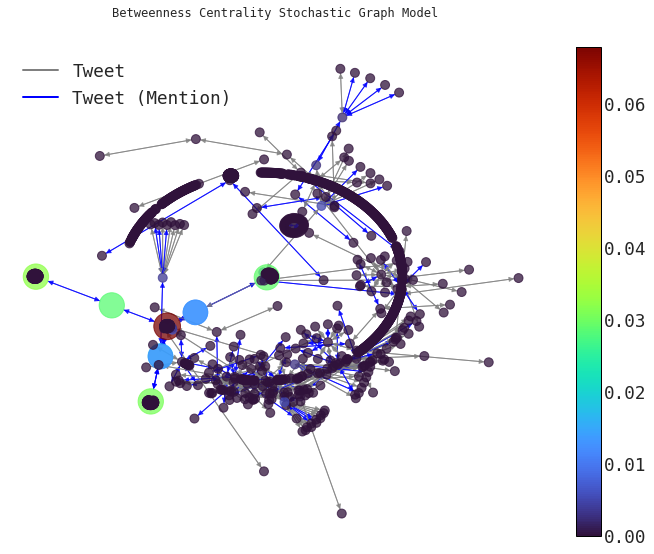

In [75]:
sDigx = nx.stochastic_graph((tnx.to_directed()))  
node_colors = list(nx.get_node_attributes(sDigx,'color').values())
edge_colors = list(nx.get_edge_attributes(sDigx,'color').values())

node_colors = list(nx.get_node_attributes(sDigx,'betweenness_centrality').values())

cmap=plt.cm.turbo
vmin = min(node_colors)
vmax = max(node_colors)

fig, ax = plt.subplots(figsize=(12, 9))
nx.draw(sDigx, 
        pos=nx.kamada_kawai_layout(sDigx),
        ax=ax, 
        node_size=[customizeNodesize(i) for i in bc_tnx.values()], 
        node_color=node_colors, 
        edge_color=edge_colors,
        width=1.0,
        font_size=10.0,
        font_color="#002966",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.75)
ax.set_title(f"Betweenness Centrality Stochastic Graph Model")
ax.plot([0],[0],color="grey",label="Tweet", linewidth=2)
ax.plot([0],[0],color="blue",label="Tweet (Mention)", linewidth=2)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
ax.legend(frameon=False)

plt.savefig(f"./figures/Betweenness Centrality Stochastic Graph Model.png")

### Value Comparison: Betweeness and Percolation centralities

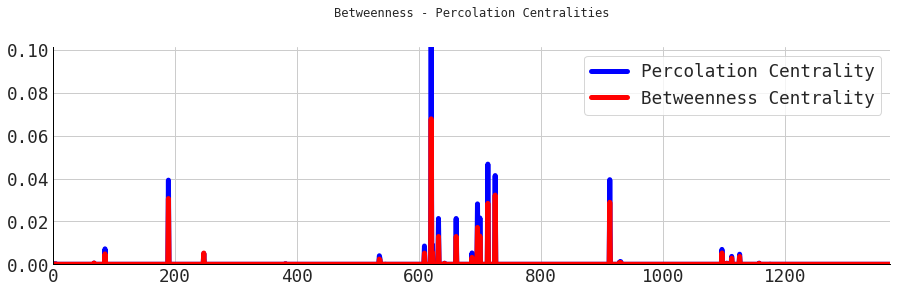

In [76]:
fig, ax = plt.subplots(figsize=(15,4))
ax.spines["top"].set_visible(False) 
ax.spines["right"].set_visible(False) 
ax.set_title(f"Betweenness - Percolation Centralities")
ax.plot(list(nx.get_node_attributes(tnx,'percolation_centrality').values()), color="blue", linewidth=5, label="Percolation Centrality");
ax.plot(list(nx.get_node_attributes(tnx,'betweenness_centrality').values()), color="red", linewidth=5, label="Betweenness Centrality");

ax.legend()
plt.savefig(f"./figures/Betweenness and Percolation - Centralities Plot.png")

### Visualizing Page Rank
Generated Graphs for page rank algorithm

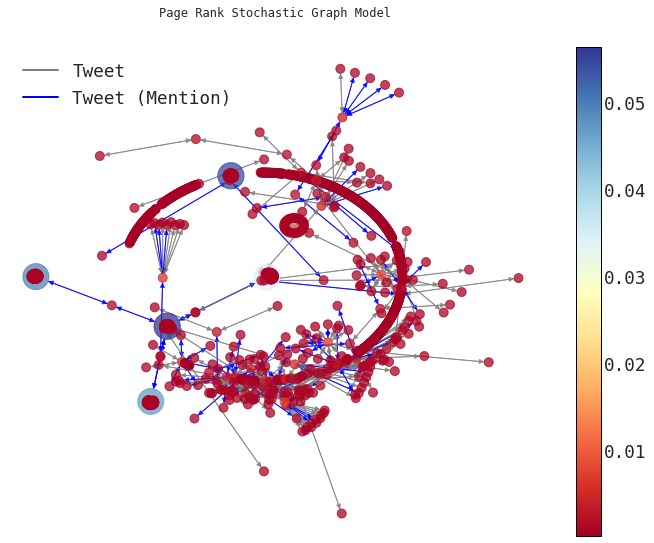

In [77]:
sDigx = nx.stochastic_graph((tnx.to_directed()))  
node_colors = list(nx.get_node_attributes(sDigx,'color').values())
edge_colors = list(nx.get_edge_attributes(sDigx,'color').values())

node_colors = list(nx.get_node_attributes(sDigx,'page_rank').values())

cmap=plt.cm.RdYlBu
vmin = min(node_colors)
vmax = max(node_colors)

fig, ax = plt.subplots(figsize=(12, 9))
nx.draw(sDigx, 
        pos=nx.kamada_kawai_layout(sDigx),
        ax=ax, 
        node_size=[customizeNodesize(i) for i in pagerank.values()], 
        node_color=node_colors, 
        edge_color=edge_colors,
        width=1.0,
        font_size=10.0,
        font_color="#002966",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.75)
ax.set_title(f"Page Rank Stochastic Graph Model")
ax.plot([0],[0],color="grey",label="Tweet", linewidth=2)
ax.plot([0],[0],color="blue",label="Tweet (Mention)", linewidth=2)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
ax.legend(frameon=False)

plt.savefig(f"./figures/Page Rank Stochastic Graph Model.png")

### Perform Random Walk Algorithm
> Forked from: https://medium.com/@gbrnc28/random-walk-method-page-rank-algorithm-using-networkx-7da8696ecc38

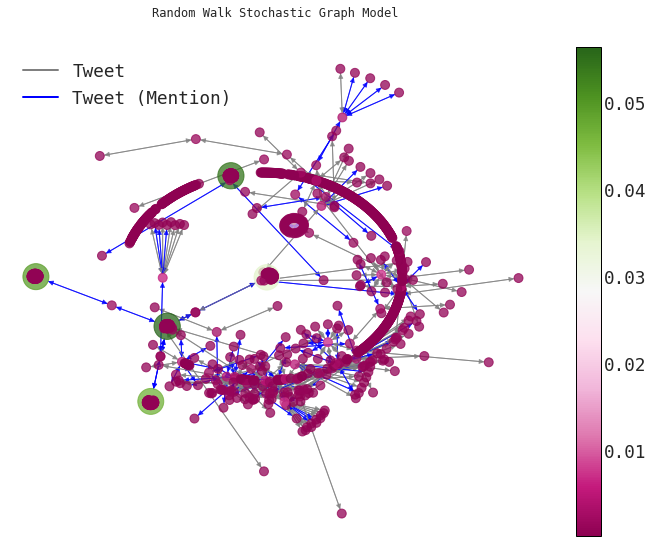

In [78]:
Graph = tnx


# random_node is the start node selected randomly
random_node = random.choice([i for i in range(Graph.number_of_nodes())])
dict_counter = {} #initialise the value for all nodes as 0
for i in range(Graph.number_of_nodes()):
    dict_counter[i] = 0
# increment by traversing through all neighbors nodes
dict_counter[random_node] = dict_counter[random_node]+1

#Traversing through the neighbors of start node
for i in range(100):
    list_for_nodes = list(Graph.neighbors(random_node))
    if len(list_for_nodes)==0:# if random_node having no outgoing edges
        random_node = random.choice([i for i in range(Graph.number_of_nodes())])
        dict_counter[random_node] = dict_counter[random_node]+1
        
    else:
        random_node = random.choice(list_for_nodes) #choose a node randomly from neighbors
        dict_counter[random_node] = dict_counter[random_node]+1
        
# using pagerank() method to provide ranks for the nodes        
rank_node = nx.pagerank(Graph)

#sorting the values of rank and random walk of respective nodes
sorted_rank = sorted(rank_node.items(), key=operator.itemgetter(1))
sorted_random_walk = sorted(dict_counter.items(), key=operator.itemgetter(1))
# print(sorted_rank)
# print(sorted_random_walk)

# parse random walk with the rest of the network analysis attributes

rw_dx = {}

for i,x in enumerate(rank_node.items()):
    rw_dx[i] = {"random_walk":x[1]}

nx.set_node_attributes(tnx, rw_dx)

# visualiza network with random walk

sDigx = nx.stochastic_graph((tnx.to_directed()))  
node_colors = list(nx.get_node_attributes(sDigx,'color').values())
edge_colors = list(nx.get_edge_attributes(sDigx,'color').values())

node_colors = list(nx.get_node_attributes(sDigx,'random_walk').values())

cmap=plt.cm.PiYG
vmin = min(node_colors)
vmax = max(node_colors)

fig, ax = plt.subplots(figsize=(12, 9))
nx.draw(sDigx, 
        pos=nx.kamada_kawai_layout(sDigx),
        ax=ax, 
        node_size=[customizeNodesize(i) for i in nx.get_node_attributes(sDigx,'random_walk').values()], 
        node_color=node_colors, 
        edge_color=edge_colors,
        width=1.0,
        font_size=10.0,
        font_color="#002966",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.75)
ax.set_title(f"Random Walk Stochastic Graph Model")
ax.plot([0],[0],color="grey",label="Tweet", linewidth=2)
ax.plot([0],[0],color="blue",label="Tweet (Mention)", linewidth=2)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
ax.legend(frameon=False)

plt.savefig(f"./figures/Random Walk Stochastic Graph Model.png")

# nodes_dx contains the processed networkx graph data
nodes_dx = list(tnx.nodes(data=True))


### Random Walk Plot

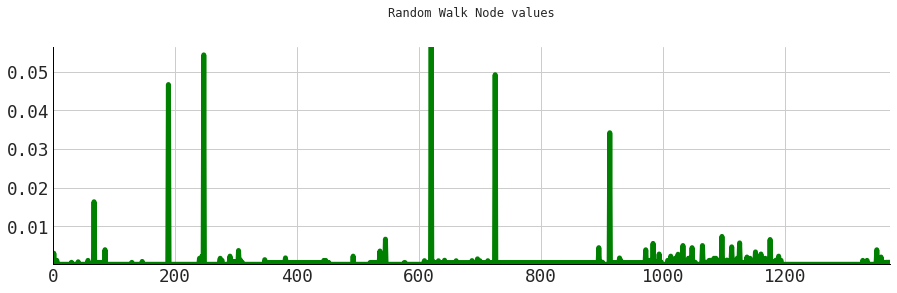

In [79]:
random_walk_values = nx.get_node_attributes(tnx,'random_walk').values()

figx = (15,4)
fig, ax = plt.subplots(figsize=figx)
ax.spines["top"].set_visible(False) 
ax.spines["right"].set_visible(False) 
ax.set_title(f"Random Walk Node values")

ax.plot(random_walk_values, color="green", linewidth=5.0);
plt.savefig(f"./figures/Random Walk Values.png")


### Implementing New Equations
> Note: The following Equations will be implemented as functions to be used on each node for the table
Equations to Implement:
- Mass Equivalent Per Node
- Energy Equivalent Per Node
- Critical Threshold Per Node

In [80]:
def mass_equivalent(degree):
    result = (degree/nx.density(tnx)) * (3.19**-38)
    return result

def energy_equivalent(me):
    result = me * speed_of_light_squared * np.average(efx)
    return result

def critical_threshold_of_node_before_node_virality(ee):
    result = ((ee*np.average(np.concatenate((list(bc_tnx.values()), list(percolation_cx.values()))))) / np.average(efx)) * np.average(efx)
    return result

def critical_threshold_of_node_after_node_virality(ee):
    result = ((ee*np.average(np.concatenate((list(bc_tnx.values()), list(percolation_cx.values()))))  * vob) / np.average(efx)) * np.average(efx)
    return result

### Generate Tables for the 2nd network analysis

In [81]:
network_timeseries = {}
network_node_classifications = {}

# create network timeseries data

for index, row in input_data[range_start:range_end].iterrows():
    tweet_date = moment.date(row["tweet_created_at"]).format("YYYY-MM-DD")

    if tweet_date not in network_timeseries:
       network_timeseries[tweet_date] = 5
    else:
       network_timeseries[tweet_date] += 1

    bot_type = ""   

    if row["from_user_type"] == "bot":
       network_timeseries[tweet_date] += 1
       bot_type = row["from_user_bot_type"]
    else:
       bot_type = "false (human account)"   

       

    node_item = {
        "id": index,
        "username": row["from_user_screen_name"],
        "bot_type": bot_type,
        "user_type": row["from_user_type"],
        "origin_tweet_date": tweet_date,
        "tweet_url": row["tweet_url"],
        "degree": network_timeseries[tweet_date], 
        "node_entanglement": 0,
        "eigenvector_centrality": 0,
        "betweenness_centrality": 0,
        "clique_number": 0,
        "before_percolation": 0,
        "after_percolation": 0,
        "page_rank": 0,
        "mass_equivalent": 0,
        "energy_equivalent": 0,
        "critical_threshold_before_node_virality": 0,
        "critical_threshold_after_node_virality": 0,
    }

    if row["from_user_screen_name"] not in network_node_classifications:
       network_node_classifications[row["from_user_screen_name"]] = node_item
    else:   
       network_node_classifications[row["from_user_screen_name"]]["degree"] += network_timeseries[tweet_date]

   
# sort entries
sorted(network_timeseries.keys())
     

# print(network_timeseries)

tsl = list(network_timeseries.keys())

start_date = tsl[0]
end_year = moment.date(tsl[len(tsl)-1]).format("YYYY")

dates = date_range(start_date, f"{end_year}-12-30")
data = np.random.randint(0, 1, len(dates))

timeframe_data = {}

for date in dates:
   dx = moment.date(date).format("YYYY-MM-DD")
   timeframe_data[dx] = 180

for dx in list(network_timeseries.keys()): 
   timeframe_data[dx] = network_timeseries[dx]

# preprocess node network classifications
network_node_classifications = list(network_node_classifications.values())
# sort by degree descending order
network_node_classifications = sorted(network_node_classifications, key = lambda i: i['degree'],reverse=True)

# create dictionary for the network dataset

htx = dict(nodes_dx)

# correlate datasets

for i, ix in enumerate(network_node_classifications):
   current_node = ix["username"]
   match = next(item for item in htx.values() if item["username"] == current_node)
   if match:
      network_node_classifications[i]["node_entanglement"] = match.get("node_entanglement", 0)
      network_node_classifications[i]["eigenvector_centrality"] = match.get("eigenvector_centrality", 0)
      network_node_classifications[i]["betweenness_centrality"] = match.get("betweenness_centrality", 0)
      network_node_classifications[i]["closeness_centrality"] = match.get("closeness_centrality", 0)
      network_node_classifications[i]["clique_number"] = match.get("clique_number", 0)
      network_node_classifications[i]["before_percolation"] =  match.get("betweenness_centrality", 0)
      network_node_classifications[i]["after_percolation"] =  match.get("percolation_centrality", 0)
      network_node_classifications[i]["page_rank"] =  match.get("page_rank", 0)
      network_node_classifications[i]["random_walk"] =  match.get("random_walk", 0)
      network_node_classifications[i]["mass_equivalent"] = mass_equivalent(ix["degree"])
      network_node_classifications[i]["energy_equivalent"] = energy_equivalent(mass_equivalent(ix["degree"]))
      network_node_classifications[i]["critical_threshold_before_node_virality"] = critical_threshold_of_node_before_node_virality(energy_equivalent(mass_equivalent(ix["degree"])))
      network_node_classifications[i]["critical_threshold_after_node_virality"] = critical_threshold_of_node_after_node_virality(energy_equivalent(mass_equivalent(ix["degree"])))
   

mx_table = pd.DataFrame(network_node_classifications)

print("Complete Table - Sorted by Degree")
display(mx_table)
mx_table.to_csv("./dataset/influential_nodes_and_network_analysis.csv")

Complete Table - Sorted by Degree


id         username               bot_type user_type origin_tweet_date  \
0   978          newsmax                spammer       bot        2021-05-26   
1   434  JonPort79449036  false (human account)     human        2021-10-09   
2   308       nickisnest  false (human account)     human        2021-08-13   
3   591        CobyJay41  false (human account)     human        2021-08-11   
4   155           bev768  false (human account)     human        2021-10-07   
..  ...              ...                    ...       ...               ...   
90  867         Sbartol3  false (human account)     human        2021-05-26   
91  887     SmithMEGA007  false (human account)     human        2021-07-15   
92  733       sgibbsters  false (human account)     human        2021-08-16   
93  917  CrashingJustice  false (human account)     human        2021-05-23   
94  848  DonnaOw66990971  false (human account)     human        2021-05-24   

                                            tweet_url  degree  \
0   https://twitter.com/newsmax/status/13975977479...   34672   
1   https://twitter.com/JonPort79449036/status/144...   15721   
2   https://twitter.com/nickisnest/status/14260638...    2881   
3   https://twitter.com/CobyJay41/status/142556404...    2473   
4   https://twitter.com/bev768/status/144620171511...    2285   
..                                                ...     ...   
90  https://twitter.com/Sbartol3/status/1397380162...      11   
91  https://twitter.com/SmithMEGA007/status/141555...      10   
92  https://twitter.com/sgibbsters/status/14272429...       9   
93  https://twitter.com/CrashingJustice/status/139...       9   
94  https://twitter.com/DonnaOw66990971/status/139...       5   

    node_entanglement  eigenvector_centrality  betweenness_centrality  \
0           -0.000017            3.677661e-03                0.005252   
1           -0.000017            6.918439e-02                0.030672   
2           -0.004863            4.278914e-02                0.032280   
3            0.000000            3.312252e-02                0.028924   
4            0.000000            7.014639e-01                0.067858   
..                ...                     ...                     ...   
90           0.000000            6.719332e-03                0.000000   
91           0.000000           1.231923e-104                0.000001   
92           0.000000           2.630277e-117                0.000000   
93           0.000000           1.151814e-163                0.000000   
94           0.000000           2.630277e-117                0.000000   

    clique_number  before_percolation  after_percolation  page_rank  \
0               2            0.005252           0.005061   0.054299   
1               1            0.030672           0.039252   0.046632   
2               2            0.032280           0.041396   0.049177   
3               2            0.028924           0.039471   0.034179   
4               1            0.067858           0.101430   0.056377   
..            ...                 ...                ...        ...   
90              1            0.000000           0.000000   0.000703   
91              2            0.000001           0.000001   0.001744   
92              2            0.000000           0.000000   0.001195   
93              2            0.000000           0.000000   0.000179   
94              2            0.000000           0.000000   0.001195   

    mass_equivalent  energy_equivalent  \
0      3.387092e-12       6.509881e-13   
1      1.535777e-12       2.951714e-13   
2      2.814436e-13       5.409255e-14   
3      2.415862e-13       4.643210e-14   
4      2.232206e-13       4.290228e-14   
..              ...                ...   
90     1.074585e-15       2.065318e-16   
91     9.768954e-16       1.877561e-16   
92     8.792059e-16       1.689805e-16   
93     8.792059e-16       1.689805e-16   
94     4.884477e-16       9.387807e-17   

    critical_threshold_before_node_viral

### Table for Network Statistics
this table will contain the following values for the rows and columns:

*Columns:* 
1. Degree
2. Entanglement per node
3. Eigenvector Centrality
4. Betweenness Centrality
5. Closeness Centrality
6. Clique Number
7. Before Percolation Centrality
8. After Percolation Centrality
9. Page Rank
10. Random Walk
11. Mass Equivalent
12. Energy Equivalent
13. Critical Threshold

*Rows:*
1. Total per column 
2. Mean per column
3. Standard Deviation per column

In [82]:
nstats_total = {
    "value": "Total",
    "degree": np.sum(mx_table["degree"].tolist()), 
    "node_entanglement": np.sum(mx_table["node_entanglement"].tolist()),
    "eigenvector_centrality": np.sum(mx_table["eigenvector_centrality"].tolist()),
    "betweenness_centrality": np.sum(mx_table["betweenness_centrality"].tolist()),
    "closeness_centrality": np.sum(mx_table["closeness_centrality"].tolist()),
    "clique_number": np.sum(mx_table["clique_number"].tolist()),
    "before_percolation": np.sum(mx_table["before_percolation"].tolist()),
    "after_percolation": np.sum(mx_table["after_percolation"].tolist()),
    "page_rank": np.sum(mx_table["page_rank"].tolist()),
    "random_walk":  np.sum(mx_table["random_walk"].tolist()),
    "mass_equivalent": np.sum(mx_table["mass_equivalent"].tolist()),
    "energy_equivalent": np.sum(mx_table["energy_equivalent"].tolist()),
    "critical_threshold_before_node_virality": np.sum(mx_table["critical_threshold_before_node_virality"].tolist()),
    "critical_threshold_after_node_virality": np.sum(mx_table["critical_threshold_after_node_virality"].tolist()),
}

nstats_mean = {
    "value": "Mean",
    "degree": np.mean(mx_table["degree"].tolist()), 
    "node_entanglement": np.mean(mx_table["node_entanglement"].tolist()),
    "eigenvector_centrality": np.mean(mx_table["eigenvector_centrality"].tolist()),
    "betweenness_centrality": np.mean(mx_table["betweenness_centrality"].tolist()),
    "closeness_centrality": np.sum(mx_table["closeness_centrality"].tolist()),
    "clique_number": np.mean(mx_table["clique_number"].tolist()),
    "before_percolation": np.mean(mx_table["before_percolation"].tolist()),
    "after_percolation": np.mean(mx_table["after_percolation"].tolist()),
    "page_rank": np.mean(mx_table["page_rank"].tolist()),
    "random_walk":  np.mean(mx_table["random_walk"].tolist()),
    "mass_equivalent": np.mean(mx_table["mass_equivalent"].tolist()),
    "energy_equivalent": np.mean(mx_table["energy_equivalent"].tolist()),
    "critical_threshold_before_node_virality": np.mean(mx_table["critical_threshold_before_node_virality"].tolist()),
    "critical_threshold_after_node_virality": np.mean(mx_table["critical_threshold_after_node_virality"].tolist()),
}

nstats_std = {
    "value": "Standard Deviation",
    "degree": np.std(mx_table["degree"].tolist()), 
    "node_entanglement": np.std(mx_table["node_entanglement"].tolist()),
    "eigenvector_centrality": np.std(mx_table["eigenvector_centrality"].tolist()),
    "betweenness_centrality": np.std(mx_table["betweenness_centrality"].tolist()),
    "closeness_centrality": np.sum(mx_table["closeness_centrality"].tolist()),
    "clique_number": np.std(mx_table["clique_number"].tolist()),
    "before_percolation": np.std(mx_table["before_percolation"].tolist()),
    "after_percolation": np.std(mx_table["after_percolation"].tolist()),
    "page_rank": np.std(mx_table["page_rank"].tolist()),
    "random_walk":  np.std(mx_table["random_walk"].tolist()),
    "mass_equivalent": np.std(mx_table["mass_equivalent"].tolist()),
    "energy_equivalent": np.std(mx_table["energy_equivalent"].tolist()),
    "critical_threshold_before_node_virality": np.std(mx_table["critical_threshold_before_node_virality"].tolist()),
    "critical_threshold_after_node_virality": np.std(mx_table["critical_threshold_after_node_virality"].tolist()),
}


nstats = [nstats_total, nstats_mean, nstats_std]


ns_table = pd.DataFrame(nstats)

print("Network Statistics Table")
display(ns_table)
ns_table.to_csv("./dataset/network_statistics_per_column.csv")

Network Statistics Table


value        degree  node_entanglement  \
0               Total  76576.000000          -0.053915   
1                Mean    806.063158          -0.000568   
2  Standard Deviation   3865.831286           0.002318   

   eigenvector_centrality  betweenness_centrality  closeness_centrality  \
0                0.889315                0.186330              1.362014   
1                0.009361                0.001961              1.362014   
2                0.071943                0.008685              1.362014   

   clique_number  before_percolation  after_percolation  page_rank  \
0     164.000000            0.186330           0.254987   0.425397   
1       1.726316            0.001961           0.002684   0.004478   
2       0.445849            0.008685           0.012391   0.010666   

   random_walk  mass_equivalent  energy_equivalent  \
0     0.425397     7.480675e-12       1.437761e-12   
1     0.004478     7.874394e-14       1.513433e-14   
2     0.010666     3.776513e-13       7.258336e-14   

   critical_threshold_before_node_virality  \
0                             3.731756e-16   
1                             3.928164e-18   
2                             1.883924e-17   

   critical_threshold_after_node_virality  
0                            2.716012e-16  
1                            2.858960e-18  
2                            1.371140e-17

### Generate Sub tables from network analysis

In [83]:
print("Percolation Centrality Table (Before and after comparison)")

def bp_centrality_change(row):
    if row["betweenness_centrality"] > row["percolation_centrality"]:
        return "decrease"
    if row["betweenness_centrality"] < row["percolation_centrality"]:
        return "increase"
    if row["betweenness_centrality"] == row["percolation_centrality"]:
        return "no change"

# parse degreee influence to network data
for i, x in enumerate(htx.values()):
    htx[i]["degree"] = 0
    

pct = pd.DataFrame.from_dict(htx.values())
prt = pd.DataFrame.from_dict(htx.values())
rwt = pd.DataFrame.from_dict(htx.values())


# update degree values
for i, x in enumerate(network_node_classifications):
    pct.loc[pct["username"] == x["username"], ["degree"]] = x['degree']
    prt.loc[pct["username"] == x["username"], ["degree"]] = x['degree']
    rwt.loc[pct["username"] == x["username"], ["degree"]] = x['degree']

    

pct = pct[["username","betweenness_centrality", "percolation_centrality","degree"]]
pct["change"] = pct.apply(lambda row: bp_centrality_change(row), axis=1)
pct = pct.rename({"betweenness_centrality": "before_percolation", "percolation_centrality": "after_percolation"}, axis=1)
pct = pct.sort_values(by=["degree"], ascending=False)
display(pct)
pct.to_csv("./dataset/percolation_before_and_after.csv")

print("Page Rank Table")
prt = prt[["username","page_rank","degree"]]
prt = prt.sort_values(by=["degree"], ascending=False)
display(prt)
pct.to_csv("./dataset/page_rank_nodes.csv")

print("Random Walk Table")
rwt = rwt[["username","random_walk","degree"]]
rwt = rwt.sort_values(by=["degree"],ascending=False)
display(rwt)
pct.to_csv("./dataset/random_walk_nodes.csv")

Percolation Centrality Table (Before and after comparison)


username  before_percolation  after_percolation  degree  \
247           newsmax            0.005252           0.005061   34672   
189   JonPort79449036            0.030672           0.039252   15721   
725        nickisnest            0.032280           0.041396    2881   
913         CobyJay41            0.028924           0.039471    2473   
620            bev768            0.067858           0.101430    2285   
...               ...                 ...                ...     ...   
476     liz_ledbetter            0.000000           0.000000       0   
475        saber_pack            0.000000           0.000000       0   
474    lawilliams1803            0.000000           0.000000       0   
473   HelloRobbieRose            0.000000           0.000000       0   
1373     lissandro_dp            0.000000           0.000000       0   

         change  
247    decrease  
189    increase  
725    increase  
913    increase  
620    increase  
...         ...  
476   no change  
475   no change  
474   no change  
473   no change  
1373  no change  

[1374 rows x 5 columns]

Page Rank Table


username  page_rank  degree
247           newsmax   0.054299   34672
189   JonPort79449036   0.046632   15721
725        nickisnest   0.049177    2881
913         CobyJay41   0.034179    2473
620            bev768   0.056377    2285
...               ...        ...     ...
476     liz_ledbetter   0.000179       0
475        saber_pack   0.000179       0
474    lawilliams1803   0.000179       0
473   HelloRobbieRose   0.000179       0
1373     lissandro_dp   0.000696       0

[1374 rows x 3 columns]

Random Walk Table


username  random_walk  degree
247           newsmax     0.054299   34672
189   JonPort79449036     0.046632   15721
725        nickisnest     0.049177    2881
913         CobyJay41     0.034179    2473
620            bev768     0.056377    2285
...               ...          ...     ...
476     liz_ledbetter     0.000179       0
475        saber_pack     0.000179       0
474    lawilliams1803     0.000179       0
473   HelloRobbieRose     0.000179       0
1373     lissandro_dp     0.000696       0

[1374 rows x 3 columns]

### Generated Table from 2nd Network Analysis
> Note: For manual Tracing purposes. The nodes are not sorted and not filtered by the degree of influence. The table contains the complete input data.

In [84]:
network_tracing_table = pd.DataFrame(htx.values())
nxt_table = pd.DataFrame(network_tracing_table)
nxt_table = nxt_table[["username","bot_type","node_entanglement", "eigenvector_centrality", "betweenness_centrality", "closeness_centrality", "clique_number", "page_rank", "random_walk"]]
display(nxt_table)

nxt_table.to_csv("./dataset/2nd_network_analysis_raw_data.csv")

username bot_type  node_entanglement  eigenvector_centrality  \
0                 ABC  spammer          -0.004863            3.121701e-41   
1         Left_of_You  spammer          -0.004863            1.682293e-40   
2            politico    other          -0.004863            3.121701e-41   
3              US_FDA    other          -0.004863            3.121701e-41   
4                 CNN  spammer          -0.004863            7.817238e-40   
...               ...      ...                ...                     ...   
1369  suelymo41592882      NaN                NaN            4.864323e-66   
1370  gamaconstrucoes      NaN                NaN            4.864323e-66   
1371         aall0504      NaN                NaN            4.864323e-66   
1372       AndreaOMag      NaN                NaN            4.864323e-66   
1373     lissandro_dp      NaN                NaN            4.864323e-66   

      betweenness_centrality  closeness_centrality  clique_number  page_rank  \
0                   0.000000              0.006790              2   0.000699   
1                   0.000134              0.009252              2   0.003053   
2                   0.000000              0.006790              2   0.000699   
3                   0.000000              0.006790              2   0.000699   
4                   0.000154              0.012757              2   0.001179   
...                      ...                   ...            ...        ...   
1369                0.000000              0.004197              2   0.000696   
1370                0.000000              0.004197              2   0.000696   
1371                0.000000              0.004197              1   0.000696   
1372                0.000000              0.004197              1   0.000696   
1373                0.000000              0.004197              1   0.000696   

      random_walk  
0        0.000699  
1        0.003053  
2        0.000699  
3        0.000699  
4        0.001179  
...           ...  
1369     0.000696  
1370     0.000696  
1371     0.000696  
1372     0.000696  
1373     0.000696  

[1374 rows x 9 columns]

## Connectome Mapper Visualizations (Adjacency Matrices)
- Use data from 2nd Network Analysis table
- Project as an adjcency Matrix

## Calculation of connectome harmonics
- Try to use PyGSP to Visualized Connections of the connectome mapper

## Phase Factor (New Equation)
1. Implement new equations based on paper oultline
2. Plot Histrogram - Check if 3d is possible